# DSC510 Group Project: Ames Housing Dataset

## Authors

- Marios Theofanous
- Antonis Alexandrou
- Ioannis Demetriou

## Abstract

The housing market is a key domain within real estate and economics, where
understanding property values plays an important role for buyers, sellers, investors,
and policymakers. A complex mix of factors are influencing the prices, for example
location, physical characteristics, neighborhood amenities, and economic conditions.
Accurately estimating a property’s value can help stakeholders make informed
decisions, optimize investments, and improve affordability analyses.

In [28]:
# Importing Libraries

import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.feature_selection import f_regression, RFECV, SelectFromModel, SelectKBest, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

sns.set_palette("viridis")

## Dataset

The analysis will use the "Ames Housing Dataset
" dataset obtained from
[here](https://www.kaggle.com/datasets/prevek18/ames-housing-dataset)
at the time of writing. 

In this section we will load and inspect the dataset, make a preliminary inspection for missing data and
prepare it for analysis by casting to appropriate types and other feature engineering.


### Load Dataset

In [29]:
# original = pd.read_csv('./data/AmesHousing.csv', keep_default_na=False, na_values=['', ' ', 'na', 'NA', 'N/A']) # Specify list because "None" is valid
original = pd.read_csv('./data/AmesHousing.csv')
original

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000


### Dataset Shape & Feature Types

Our dataset contains a relatively large number of features. We need to understand what type they are - quantitative or qualitative, and if the latter, ordinal or categorical.

In [30]:
rows, cols = original.shape
print(f"Dataset shape: {rows} rows × {cols} columns")

Dataset shape: 2930 rows × 82 columns


In [31]:
# Here we print all of the features with their current type and intigative 5 example values
print(
    original.head().T.assign(types=original.dtypes.values).to_string()
)

                         0          1          2          3          4    types
Order                    1          2          3          4          5    int64
PID              526301100  526350040  526351010  526353030  527105010    int64
MS SubClass             20         20         20         20         60    int64
MS Zoning               RL         RH         RL         RL         RL   object
Lot Frontage         141.0       80.0       81.0       93.0       74.0  float64
Lot Area             31770      11622      14267      11160      13830    int64
Street                Pave       Pave       Pave       Pave       Pave   object
Alley                  NaN        NaN        NaN        NaN        NaN   object
Lot Shape              IR1        Reg        IR1        Reg        IR1   object
Land Contour           Lvl        Lvl        Lvl        Lvl        Lvl   object
Utilities           AllPub     AllPub     AllPub     AllPub     AllPub   object
Lot Config          Corner     Inside   

The description of what each feature describes is available [here](https://cran.r-project.org/web/packages/AmesHousing/AmesHousing.pdf)

- `Order`: Observation number
- `PID`: Parcel identification number - can be used with city web site for parcel review.
- `MS SubClass`: Identifies the type of dwelling involved in the sale.
- `MS Zoning`: Identifies the general zoning classification of the sale.
- `Lot Frontage`: Linear feet of street connected to property
- `Lot Area`: Lot size in square feet
- `Street`: Type of road access to property
- `Alley`: Type of alley access to property
- `Lot Shape`: General shape of property
- `Land Contour`: Flatness of the property
- `Utilities`: Type of utilities available
- `Lot Config`: Lot configuration
- `Land Slope`: Slope of property
- `Neighborhood`: Physical locations within Ames city limits (map available)
- `Condition 1`: Proximity to various conditions
- `Condition 2`: Proximity to various conditions (if more than one is present)
- `Bldg Type`: Type of dwelling
- `House Style`: Style of dwelling
- `Overall Qual`: Rates the overall material and finish of the house
- `Overall Cond`: Rates the overall condition of the house
- `Year Built`: Original construction date
- `Year Remod/Add`: Remodel date (same as construction date if no remodeling or additions)
- `Roof Style`: Type of roof
- `Roof Matl`: Roof material
- `Exterior 1`: Exterior covering on house
- `Exterior 2`: Exterior covering on house (if more than one material)
- `Mas Vnr Type`: Masonry veneer type
- `Mas Vnr Area`: Masonry veneer area in square feet
- `Exter Qual`: Evaluates the quality of the material on the exterior
- `Exter Cond`: Evaluates the present condition of the material on the exterior
- `Foundation`: Type of foundation
- `Bsmt Qual`: Evaluates the height of the basement
- `Bsmt Cond`: Evaluates the general condition of the basement
- `Bsmt Exposure`: Refers to walkout or garden level walls
- `BsmtFin Type 1`: Rating of basement finished area
- `BsmtFin SF 1`: Type 1 finished square feet
- `BsmtFinType 2`: Rating of basement finished area (if multiple types)
- `BsmtFin SF 2`: Type 2 finished square feet
- `Bsmt Unf SF`: Unfinished square feet of basement area
- `Total Bsmt SF`: Total square feet of basement area
- `Heating`: Type of heating
- `HeatingQC`: Heating quality and condition
- `Central Air`: Central air conditionisng
- `Electrical`: Electrical system
- `1st Flr SF`: First Floor square feet
- `2nd Flr SF`: Second floor square feet
- `Low Qual Fin SF`: Low quality finished square feet (all floors)
- `Gr Liv Area`: Above grade (ground) living area square feet
- `Bsmt Full Bath`: Basement full bathrooms
- `Bsmt Half Bath`: Basement half bathrooms
- `Full Bath`: Full bathrooms above grade
- `Half Bath`: Half baths above grade
- `Bedroom`: Bedrooms above grade (does NOT include basement bedrooms)
- `Kitchen`: Kitchens above grade
- `KitchenQual`: Kitchen quality
- `TotRmsAbvGrd`: Total rooms above grade (does not include bathrooms)
- `Functional`: Home functionality (Assume typical unless deductions are warranted)
- `Fireplaces`: Number of fireplaces
- `FireplaceQu`: Fireplace quality
- `Garage Type`: Garage location
- `Garage Yr Blt`: Year garage was built
- `Garage Finish`: Interior finish of the garage
- `Garage Cars`: Size of garage in car capacity
- `Garage Area`: Size of garage in square feet
- `Garage Qual`: Garage quality
- `Garage Cond`: Garage condition
- `Paved Drive`: Paved driveway
- `Wood Deck SF`: Wood deck area in square feet
- `Open Porch SF`: Open porch area in square feet
- `Enclosed Porch`: Enclosed porch area in square feet
- `3-Ssn Porch`: Three season porch area in square feet
- `Screen Porch`: Screen porch area in square feet
- `Pool Area`: Pool area in square feet
- `Pool QC`: Pool quality
- `Fence`: Fence quality
- `Misc Feature`: Miscellaneous feature not covered in other categories
- `Misc Val`: $Value of miscellaneous feature
- `Mo Sold`: Month Sold
- `Yr Sold`: Year Sold
- `Sale Type`: Type of sale
- `Sale Condition`: Condition of sale

### Unique Identifier

The dataset contains two fields that could potentially be used to identify the properties: `Order` and `PID`. From domain knowledge, `PID` means "Parcel ID" - a term used in land registry to identify properties.

To verify its uniqueness across the dataset, we count the unique `PID` entries and compare against total rows.

We will then drop the `Order` column and set `PID` as index.

In [32]:
if original.PID.nunique() == original.shape[0]:
    print('PID only contains unique entries')

PID only contains unique entries


In [33]:
# Drop 'Order', set PID as index
df = original.drop(columns="Order")
df = df.set_index("PID")
df.head().T

PID,526301100,526350040,526351010,526353030,527105010
MS SubClass,20,20,20,20,60
MS Zoning,RL,RH,RL,RL,RL
Lot Frontage,141.0,80.0,81.0,93.0,74.0
Lot Area,31770,11622,14267,11160,13830
Street,Pave,Pave,Pave,Pave,Pave
...,...,...,...,...,...
Mo Sold,5,6,6,4,3
Yr Sold,2010,2010,2010,2010,2010
Sale Type,WD,WD,WD,WD,WD
Sale Condition,Normal,Normal,Normal,Normal,Normal


### Feature Encoding

We will now cast the features into types pandas and any other frameworks we can use will be able to process.

In particular we want to cast temporal features to datetime, and features that make sense as qualitative as ordinals or simply categories.

#### Temporal Features

In [37]:
# Convert temporal data to DateTime object
df['Date Sold'] = pd.to_datetime({'year': df['Yr Sold'], 'month': df['Mo Sold'], 'day': 1})

df['Garage Yr Blt'] = pd.to_datetime({'year': df['Garage Yr Blt'], 'month': 1, 'day': 1})
df['Year Built'] = pd.to_datetime({'year': df['Year Built'], 'month': 1, 'day': 1})
df['Year Remod/Add'] = pd.to_datetime({'year': df['Year Remod/Add'], 'month': 1, 'day': 1})

# House age at the time of sale
df['House Age'] = (df['Date Sold'] - df['Year Built']).dt.days / 365

# Years since last remodel until the sale
df['Since Remodel'] = (df['Date Sold'] - df['Year Remod/Add']).dt.days / 365

df['House Age'] = df['House Age'].round(1)
df['Since Remodel'] = df['Since Remodel'].round(1)

print(df[['House Age', 'Since Remodel']].head(10))

In [38]:
# We could either drop the original ones or consider them as categorical
# df.drop(columns=['Mo Sold', 'Yr Sold'], inplace=True)
df['Mo Sold'] = df['Mo Sold'].astype("category")
df['Yr Sold'] = df['Yr Sold'].astype("category")

#### Quantitative Features

We want to ensure that features containing discrete and continious values are correctly casted. For example the `Farage Cars` which contains the number of cars the garage can fit should be discrete (`Int64`), while areas, like `Pool Area` should be continuous (`float64`).

In [39]:
# Cast between integers and floats
# Features like areas makes sense to be of type float as they could contain decimal (even though our dataset does not)
# Other features that are discrete like number of rooms should be ints
df['Garage Cars'] = df['Garage Cars'].astype('Int64') # Parser considers them as float (because of missing values?)
df['Bsmt Full Bath'] = df['Bsmt Full Bath'].astype('Int64')
df['Bsmt Half Bath'] = df['Bsmt Half Bath'].astype('Int64')

df['Lot Area'] = df['Lot Area'].astype('float64')
df['1st Flr SF'] = df['1st Flr SF'].astype('float64')
df['2nd Flr SF'] = df['2nd Flr SF'].astype('float64')
df['Gr Liv Area'] = df['Gr Liv Area'].astype('float64')
df['Wood Deck SF'] = df['Wood Deck SF'].astype('float64')
df['Open Porch SF'] = df['Open Porch SF'].astype('float64')
df['Enclosed Porch'] = df['Enclosed Porch'].astype('float64')
df['3Ssn Porch'] = df['3Ssn Porch'].astype('float64')
df['Screen Porch'] = df['Screen Porch'].astype('float64')
df['Pool Area'] = df['Pool Area'].astype('float64')

#### Categorical Features

We want to correctly encode the features that are meant to be treated as categorical, and also specify the order for nomial features

In [40]:
# Most likely string features are categorical features
# We print to visually inspect to verify

for col in df.select_dtypes(include='object').columns:
    print(
        '(Possible) categorical feature:', col,
        f'Categories ({df[col].astype("category").cat.categories.size}):', df[col].astype('category').cat.categories.values
    )

(Possible) categorical feature: MS Zoning Categories (7): ['A (agr)' 'C (all)' 'FV' 'I (all)' 'RH' 'RL' 'RM']
(Possible) categorical feature: Street Categories (2): ['Grvl' 'Pave']
(Possible) categorical feature: Alley Categories (2): ['Grvl' 'Pave']
(Possible) categorical feature: Lot Shape Categories (4): ['IR1' 'IR2' 'IR3' 'Reg']
(Possible) categorical feature: Land Contour Categories (4): ['Bnk' 'HLS' 'Low' 'Lvl']
(Possible) categorical feature: Utilities Categories (3): ['AllPub' 'NoSeWa' 'NoSewr']
(Possible) categorical feature: Lot Config Categories (5): ['Corner' 'CulDSac' 'FR2' 'FR3' 'Inside']
(Possible) categorical feature: Land Slope Categories (3): ['Gtl' 'Mod' 'Sev']
(Possible) categorical feature: Neighborhood Categories (28): ['Blmngtn' 'Blueste' 'BrDale' 'BrkSide' 'ClearCr' 'CollgCr' 'Crawfor'
 'Edwards' 'Gilbert' 'Greens' 'GrnHill' 'IDOTRR' 'Landmrk' 'MeadowV'
 'Mitchel' 'NAmes' 'NPkVill' 'NWAmes' 'NoRidge' 'NridgHt' 'OldTown'
 'SWISU' 'Sawyer' 'SawyerW' 'Somerst' 'Sto

From the above output we confirm that there is no free style text since there are limited number of categories formed.

We proceed to cast all of them ast categories and manually define their order if the feature is ordinal

In [41]:
def as_categorical(col: str, ordered: bool = False):
    if ordered:
        df[col] = df[col].astype('category').cat.as_ordered()
    else:
        df[col] = df[col].astype('category')


def as_ordinal(col: str, order: list):
    df[col] = df[col].astype(pd.CategoricalDtype(categories=order, ordered=True))


for col in df.select_dtypes(include='object').columns:
    # Cast all of them as categories and then consider if they are ordinal or binary
    as_categorical(col)

### Quality and Condition Ordinal Scale

Many housing quality features in the **Ames Housing dataset** use short categorical codes that describe the overall **quality** or **condition** of a house component (e.g., basement, exterior, garage, pool, etc.).

These traits follow an **ordinal scale**, from the *lowest* to the *highest* quality level:

### Lot Shape
**General shape of property**

| Code | Meaning | Description |
|------|----------|-------------|
| **Reg** | Regular | Regular shape |
| **IR1** | Slightly Irregular | Minor irregularities |
| **IR2** | Moderately Irregular | Noticeable irregularities |
| **IR3** | Irregular | Strongly irregular shape |

**Order:** `Reg < IR1 < IR2 < IR3`



In [12]:
as_ordinal('Lot Shape', ['Reg', 'IR1', 'IR2', 'IR3'])

### Utilities
**Type of utilities available**

| Code | Meaning | Description |
|------|----------|-------------|
| **ELO** | Electricity only | Only electricity connection |
| **NoSeWa** | Electricity & Gas | No sewer or water |
| **NoSewr** | Electricity, Gas & Water | Septic tank present |
| **AllPub** | All Public Utilities | Full public utility access |

**Order:** `ELO < NoSeWa < NoSewr < AllPub`



In [13]:
as_ordinal('Utilities', ['ELO', 'NoSeWa', 'NoSewr','AllPub'])

### Land Slope
**Slope of property**

| Code | Meaning | Description |
|------|----------|-------------|
| **Sev** | Severe | Steep slope |
| **Mod** | Moderate | Medium slope |
| **Gtl** | Gentle | Slight or level slope |

**Order:** `Sev < Mod < Gtl`


In [14]:
as_ordinal('Land Slope', ['Sev', 'Mod', 'Gtl'])

### Overall Qual

**Overall material and finish of the house**

| Code | Meaning | Description |
|------|----------|-------------|
| **1** | Very Poor | Lowest quality |
| **2** | Poor | Very low quality |
| **3** | Fair | Below average |
| **4** | Below Average | Slightly poor |
| **5** | Average | Typical quality |
| **6** | Above Average | Slightly better |
| **7** | Good | Good quality |
| **8** | Very Good | Very good quality |
| **9** | Excellent | High-end materials |
| **10** | Very Excellent | Exceptional materials and finish |

**Order:** `1 < 2 < 3 < 4 < 5 < 6 < 7 < 8 < 9 < 10`

In [15]:
as_ordinal('Overall Qual', [i for i in range(1, 11)])

### Overall Cond
**Overall condition of the house**

| Code | Meaning | Description |
|------|----------|-------------|
| **1** | Very Poor | Worst overall condition |
| **2** | Poor | Bad condition |
| **3** | Fair | Fair condition |
| **4** | Below Average | Slightly below typical |
| **5** | Average | Typical condition |
| **6** | Above Average | Slightly above typical |
| **7** | Good | Good condition |
| **8** | Very Good | Very good condition |
| **9** | Excellent | Excellent condition |
| **10** | Very Excellent | Exceptional condition |

**Order:** `1 < 2 < 3 < 4 < 5 < 6 < 7 < 8 < 9 < 10`

In [16]:
as_ordinal('Overall Cond', [i for i in range(1, 11)])

### Exter Qual
**Quality of the material on the exterior**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | Lowest exterior quality |
| **Fa** | Fair | Below average |
| **TA** | Typical / Average | Typical exterior material |
| **Gd** | Good | Good quality material |
| **Ex** | Excellent | Highest quality exterior material |

**Order:** `Po < Fa < TA < Gd < Ex`

In [17]:
as_ordinal('Exter Qual', ['Po', 'Fa', 'TA', 'Gd', 'Ex'])

### Exter Cond
**Condition of the material on the exterior**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | Severely worn |
| **Fa** | Fair | Noticeably aged |
| **TA** | Typical / Average | Typical wear |
| **Gd** | Good | Minor wear |
| **Ex** | Excellent | Excellent condition |

**Order:** `Po < Fa < TA < Gd < Ex`

In [18]:
as_ordinal('Exter Cond', ['Po', 'Fa', 'TA', 'Gd', 'Ex'])

### Bsmt Qual
**Height of basement**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | <70 inches |
| **Fa** | Fair | 70–79 inches |
| **TA** | Typical | 80–89 inches |
| **Gd** | Good | 90–99 inches |
| **Ex** | Excellent | ≥100 inches |
| **NA** | No Basement | No basement present |

**Order:** `Po < Fa < TA < Gd < Ex < NA`

In [19]:
as_ordinal('Bsmt Qual', ['Po', 'Fa', 'TA', 'Gd', 'Ex'])

### Bsmt Cond
**General condition of basement**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | Severe cracking or wetness |
| **Fa** | Fair | Dampness or cracking |
| **TA** | Typical | Slight dampness allowed |
| **Gd** | Good | Minor issues |
| **Ex** | Excellent | Excellent condition |
| **NA** | No Basement | No basement present |

**Order:** `Po < Fa < TA < Gd < Ex < NA`

In [20]:
as_ordinal('Bsmt Cond', ['Po', 'Fa', 'TA', 'Gd', 'Ex'])

### Bsmt Exposure
**Walkout or garden-level walls**

| Code | Meaning | Description |
|------|----------|-------------|
| **No** | No Exposure | Fully underground |
| **Mn** | Minimum | Minimal exposure |
| **Av** | Average | Average exposure |
| **Gd** | Good | Good exposure |
| **NA** | No Basement | No basement present |

**Order:** `No < Mn < Av < Gd < NA`

In [21]:
as_ordinal('Bsmt Exposure', ['Po', 'Fa', 'TA', 'Gd', 'Ex'])

### BsmtFin Type 1 / 2
**Basement finished area type**

| Code | Meaning | Description |
|------|----------|-------------|
| **Unf** | Unfinished | Not finished |
| **LwQ** | Low Quality | Low-quality finish |
| **Rec** | Recreation | Average rec room |
| **BLQ** | Below Avg Living Quarters | Slightly below average |
| **ALQ** | Average Living Quarters | Typical finish |
| **GLQ** | Good Living Quarters | High-quality finish |
| **NA** | No Basement | No basement |

**Order:** `Unf < LwQ < Rec < BLQ < ALQ < GLQ < NA`

In [22]:
as_ordinal('BsmtFin Type 1', ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'])

### Heating QC
**Heating quality and condition**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | Inefficient or old system |
| **Fa** | Fair | Below average |
| **TA** | Typical / Average | Typical system |
| **Gd** | Good | Good condition |
| **Ex** | Excellent | Excellent heating system |

**Order:** `Po < Fa < TA < Gd < Ex`

In [23]:
as_ordinal('Heating QC', ['Po', 'Fa', 'TA', 'Gd', 'Ex'])

### Electrical
**Electrical system**

| Code | Meaning | Description |
|------|----------|-------------|
| **Mix** | Mixed | Mixed wiring types |
| **FuseP** | Poor Fuse Box | 60 AMP knob & tube |
| **FuseF** | Fair Fuse Box | 60 AMP mostly Romex |
| **FuseA** | Average Fuse Box | >60 AMP all Romex |
| **SBrkr** | Standard Breakers | Modern circuit breakers |

**Order:** `Mix < FuseP < FuseF < FuseA < SBrkr`

In [24]:
as_ordinal('Electrical', ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'])

### Kitchen Qual
**Kitchen quality**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | Lowest kitchen quality |
| **Fa** | Fair | Below average |
| **TA** | Typical / Average | Typical kitchen |
| **Gd** | Good | Good quality |
| **Ex** | Excellent | Highest kitchen quality |

**Order:** `Po < Fa < TA < Gd < Ex`

In [25]:
as_ordinal('Kitchen Qual', ['Po', 'Fa', 'TA', 'Gd', 'Ex'])

### Functional
**Home functionality**

| Code | Meaning | Description |
|------|----------|-------------|
| **Sal** | Salvage Only | Almost unlivable |
| **Sev** | Severely Damaged | Severe issues |
| **Maj2** | Major Deductions 2 | Big functionality loss |
| **Maj1** | Major Deductions 1 | Significant loss |
| **Mod** | Moderate Deductions | Moderate issues |
| **Min2** | Minor Deductions 2 | Small issues |
| **Min1** | Minor Deductions 1 | Very small issues |
| **Typ** | Typical | Fully functional |

**Order:** `Sal < Sev < Maj2 < Maj1 < Mod < Min2 < Min1 < Typ`


In [26]:
as_ordinal('Functional', ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'])

### Fireplace Qu
**Fireplace quality**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | Ben Franklin stove |
| **Fa** | Fair | Prefab basement fireplace |
| **TA** | Typical / Average | Prefab main floor |
| **Gd** | Good | Masonry main level |
| **Ex** | Excellent | Exceptional masonry fireplace |
| **NA** | No Fireplace | No fireplace present |

**Order:** `Po < Fa < TA < Gd < Ex < NA`

In [27]:
as_ordinal('Fireplace Qu', ['Po', 'Fa', 'TA', 'Gd', 'Ex'])

### Garage Finish
**Garage interior finish**

| Code | Meaning | Description |
|------|----------|-------------|
| **Unf** | Unfinished | Bare interior |
| **RFn** | Rough Finished | Partially finished |
| **Fin** | Finished | Fully finished |
| **NA** | No Garage | No garage present |

**Order:** `Unf < RFn < Fin < NA`


In [28]:
as_ordinal('Garage Finish', ['Unf', 'RFn', 'Fin'])

### Garage Qual
**Garage quality**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | Poor structure |
| **Fa** | Fair | Below average |
| **TA** | Typical / Average | Typical quality |
| **Gd** | Good | Good quality |
| **Ex** | Excellent | Excellent quality |
| **NA** | No Garage | No garage present |

**Order:** `Po < Fa < TA < Gd < Ex < NA`


In [29]:
as_ordinal('Garage Qual', ['Po', 'Fa', 'TA', 'Gd', 'Ex'])

### Garage Cond
**Garage condition**

| Code | Meaning | Description |
|------|----------|-------------|
| **Po** | Poor | Poor condition |
| **Fa** | Fair | Some wear |
| **TA** | Typical / Average | Typical condition |
| **Gd** | Good | Good condition |
| **Ex** | Excellent | Excellent condition |
| **NA** | No Garage | No garage present |

**Order:** `Po < Fa < TA < Gd < Ex < NA`


In [30]:
as_ordinal('Garage Cond', ['Po', 'Fa', 'TA', 'Gd', 'Ex'])

### Paved Drive
**Paved driveway**

| Code | Meaning | Description |
|------|----------|-------------|
| **N** | Dirt / Gravel | No pavement |
| **P** | Partial Pavement | Partially paved |
| **Y** | Paved | Fully paved |

**Order:** `N < P < Y`


In [31]:
as_ordinal('Paved Drive', ['N', 'P', 'Y'])

### Pool QC
**Pool quality**

| Code | Meaning | Description |
|------|----------|-------------|
| **Fa** | Fair | Below average |
| **TA** | Typical / Average | Typical pool |
| **Gd** | Good | Good quality |
| **Ex** | Excellent | Excellent pool |
| **NA** | No Pool | No pool present |

**Order:** `Fa < TA < Gd < Ex < NA`


In [32]:
as_ordinal('Pool QC', ['Fa', 'TA', 'Gd', 'Ex'])

### Fence
**Fence quality**

| Code | Meaning | Description |
|------|----------|-------------|
| **MnWw** | Minimum Wood/Wire | Basic fence |
| **MnPrv** | Minimum Privacy | Low privacy fence |
| **GdWo** | Good Wood | Good wooden fence |
| **GdPrv** | Good Privacy | High privacy fence |
| **NA** | No Fence | No fence present |

**Order:** `MnWw < MnPrv < GdWo < GdPrv < NA`


In [33]:
as_ordinal('Fence', ['MnWw', 'MnPrv', 'GdWo', 'GdPrv'])

**Reference:**
[https://jse.amstat.org/v19n3/decock/DataDocumentation.txt](https://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

In [34]:
# Numeric categories
# Some categories even though they are numeric, make more sense in terms of categories.
as_categorical('MS SubClass')
# In some cases the numbers relate to an natural order
# TODO: Is this a good idea?
as_categorical('Garage Cars', ordered=True)
as_categorical('Overall Qual', ordered=True)
as_categorical('Overall Cond', ordered=True)

### Missing Values

Here we inspect the dataset for missing values.

The [pandas parser](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) automatically casts some strings into `na`s, such as "None", "N/A", "NA". The next table shows what is has done

In [42]:
missing_vals = df.isnull().sum()
missing_vals = missing_vals[missing_vals > 0].sort_values(ascending=True)
print(missing_vals)

Electrical           1
Garage Cars          1
BsmtFin SF 1         1
Garage Area          1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Half Bath       2
Bsmt Full Bath       2
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
BsmtFin Type 1      80
BsmtFin Type 2      81
Bsmt Exposure       83
Garage Type        157
Garage Qual        159
Garage Cond        159
Garage Yr Blt      159
Garage Finish      159
Lot Frontage       490
Fireplace Qu      1422
Mas Vnr Type      1775
Fence             2358
Alley             2732
Misc Feature      2824
Pool QC           2917
dtype: int64


In [43]:
missing_percent = (
    df.isnull().sum() * 100 / len(df)
).sort_values(ascending=False)
 
# Display only columns with missing values
missing_percent = missing_percent[missing_percent > 0]
 
# Show nicely formatted results
print("Percentage of Missing Values per Column:\n")
print(missing_percent.round(2))

Percentage of Missing Values per Column:

Pool QC           99.56
Misc Feature      96.38
Alley             93.24
Fence             80.48
Mas Vnr Type      60.58
Fireplace Qu      48.53
Lot Frontage      16.72
Garage Yr Blt      5.43
Garage Qual        5.43
Garage Cond        5.43
Garage Finish      5.43
Garage Type        5.36
Bsmt Exposure      2.83
BsmtFin Type 2     2.76
BsmtFin Type 1     2.73
Bsmt Qual          2.73
Bsmt Cond          2.73
Mas Vnr Area       0.78
Bsmt Half Bath     0.07
Bsmt Full Bath     0.07
BsmtFin SF 1       0.03
Garage Area        0.03
BsmtFin SF 2       0.03
Bsmt Unf SF        0.03
Total Bsmt SF      0.03
Garage Cars        0.03
Electrical         0.03
dtype: float64


We see a lot of missing values, especially for rarer property features such as `Pool QC`. Closer inspection to the dataset, we notice that `Pool QC` has 'NA' for properties without a pool (i.e. whose `Pool Area` = 0).

Similarly, the `Misc Feature` is not missing rather it is not applicable (NA) - the property does not have a different feature.

The stragety that we will follow is that we will keep the existing `NA` labels, and further mark numerical features such as areas that are equal to 0 to `NA`. However if there is a feature whose absence makes sense, such as the `Alley` feature which means "no alley access", we will impute the missing values with a "None" category.   

In [44]:
for col in df.select_dtypes(include='float64').columns:
    df[col] = df[col].where(df[col] != 0.0, pd.NA)

In [45]:
df['Pool Area'].describe()

count     13.000000
mean     505.615385
std      183.222332
min      144.000000
25%      444.000000
50%      519.000000
75%      576.000000
max      800.000000
Name: Pool Area, dtype: float64

So in fact only 13 out the 2930 sold properties have a pool. Correclty identifying and setting `np.nan` to the continuous data with 0.0 for areas is critical as if we don't it will significantly alter the summary statistics.

### Statistical summary for all features

In [46]:
df.describe().T.round(2)

,count,mean,min,25%,50%,75%,max,std
MS SubClass,2930.0,57.387372,20.0,20.0,50.0,70.0,190.0,42.638025
Lot Frontage,2440.0,69.22459,21.0,58.0,68.0,80.0,313.0,23.365335
Lot Area,2930.0,10147.921843,1300.0,7440.25,9436.5,11555.25,215245.0,7880.017759
Overall Qual,2930.0,6.094881,1.0,5.0,6.0,7.0,10.0,1.411026
Overall Cond,2930.0,5.56314,1.0,5.0,5.0,6.0,9.0,1.111537
Year Built,2930,1971-05-11 06:35:37.883959048,1872-01-01 00:00:00,1954-01-01 00:00:00,1973-01-01 00:00:00,2001-01-01 00:00:00,2010-01-01 00:00:00,NaN
Year Remod/Add,2930,1984-04-07 17:37:38.293515328,1950-01-01 00:00:00,1965-01-01 00:00:00,1993-01-01 00:00:00,2004-01-01 00:00:00,2010-01-01 00:00:00,NaN
Mas Vnr Area,1159.0,255.577222,1.0,120.0,203.0,325.5,1600.0,202.970269
BsmtFin SF 1,1999.0,648.555278,2.0,352.5,602.0,873.5,5644.0,412.983506
BsmtFin SF 2,351.0,414.920228,6.0,173.5,354.0,596.0,1526.0,295.717596


# Explanatory Data Analysis

The main goal of the Explanatory Data Analysis is to understand deeper the structure of the dataset, detect missing values and outliers. Moreover the target variable Saleprice will be analyzed and various relationships between housing features is set to be uncovered. This stage is critical because it will help us choose the correct housing features for our regression models in a later stage.


## 2.1 Target Variable:Housing Sale Prices(SalePrice)

In [48]:
print("Target variable (SalePrice) statistics:")
print(df["SalePrice"].describe().round(2))

Target variable (SalePrice) statistics:
count      2930.00
mean     180796.06
std       79886.69
min       12789.00
25%      129500.00
50%      160000.00
75%      213500.00
max      755000.00
Name: SalePrice, dtype: float64


To begin with, analyzing the distribution and the boxplot of the target variable will helps us understand overall price trends, detect outliers, and check whether the data is normally distributed — an important step before applying statistical or predictive models.

### Distribution:

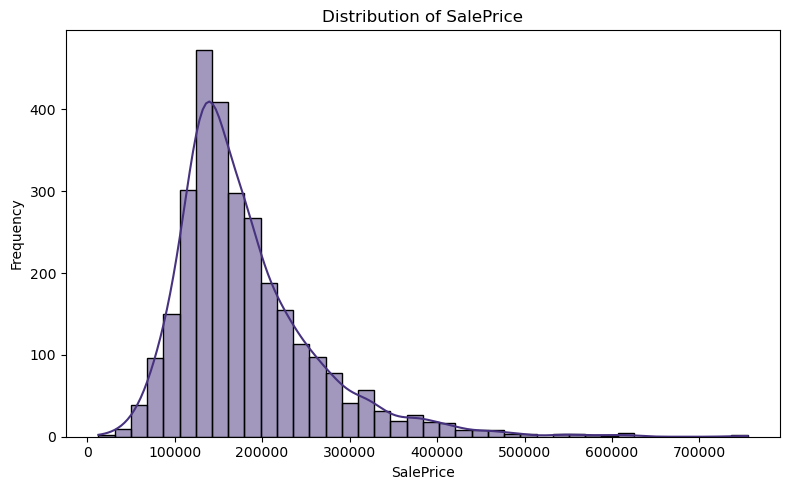

In [49]:
plt.figure(figsize=(8,5))
sns.histplot(original["SalePrice"], kde=True, bins=40)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#### Boxplot:

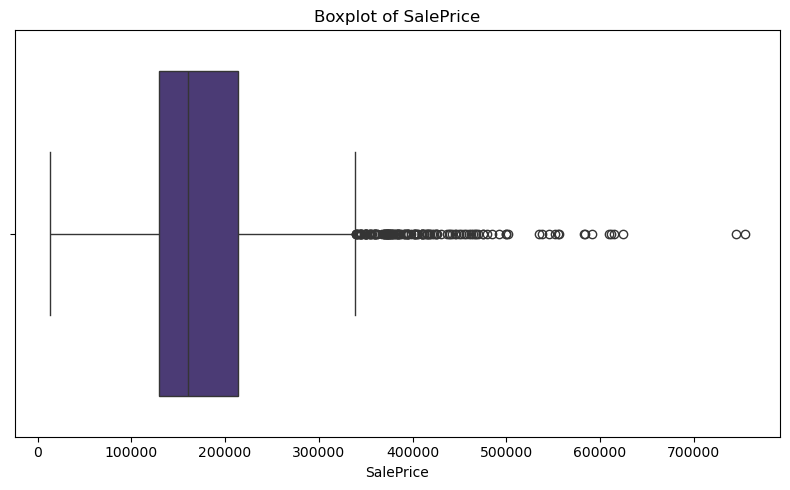

In [50]:
plt.figure(figsize=(8,5))
sns.boxplot(x=original["SalePrice"])
plt.title("Boxplot of SalePrice")
plt.xlabel("SalePrice")
plt.tight_layout()
plt.show()

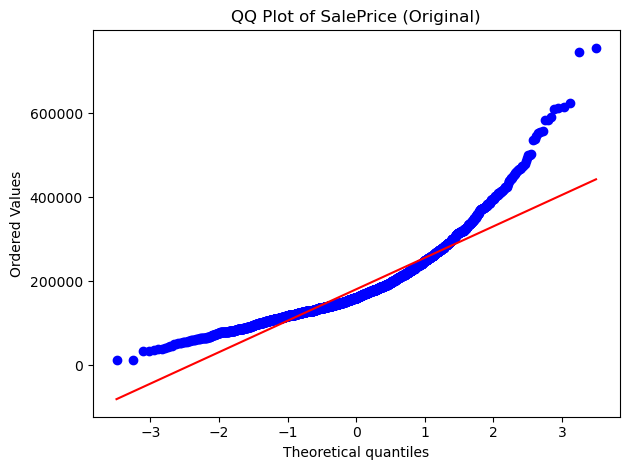

In [51]:
from scipy import stats

saleprice = df['SalePrice']

plt.plot(1,2,1)
stats.probplot(saleprice, dist="norm", plot=plt)
plt.title("QQ Plot of SalePrice (Original)")

# plt.subplot(1,2,2)
# stats.probplot(np.log1p(saleprice), dist="norm", plot=plt)
# plt.title("QQ Plot of Log(SalePrice)")

plt.tight_layout()
plt.show()


The above plots shows:
- Sale price is right-skewed
- Most houses in our dataset sold for about 100000 and 200000
- Dataset has long tail of higher values with relavite few houses being that expensive (300,000–700,000+)
- Most common sale price (mode) is around 120,000–150,000.

It confirms that the `SalePrice`, our target variable, does not follow normal distribution. Models from the GLM family such as Linear and Logistic Regression, SVM,Gaussian
NB work better with near-Gaussian data. THis motivates us to apply a (monotonic) tranformation to reduce the skewness and have more gaussian-like properties.

When considering tree based based models, like random forests, we can use the original `SalePrice` column.

For illustation purposes we visualize the log transform of `SalePrice`. Other transformations include:

- Square Root Transform
- Boxcox
- Yeo-Johnson



### Saleprice in a normal distribution form:

Before building predictive models, it’s important to ensure that the target variable — SalePrice in the Ames Housing dataset — follows a roughly normal distribution. Many regression models assume normality of residuals, and a highly skewed target can lead to biased parameter estimates and poor model performance. To address this, different transformations were applied to SalePrice: Square Root, Log, Box–Cox, and Yeo–Johnson.

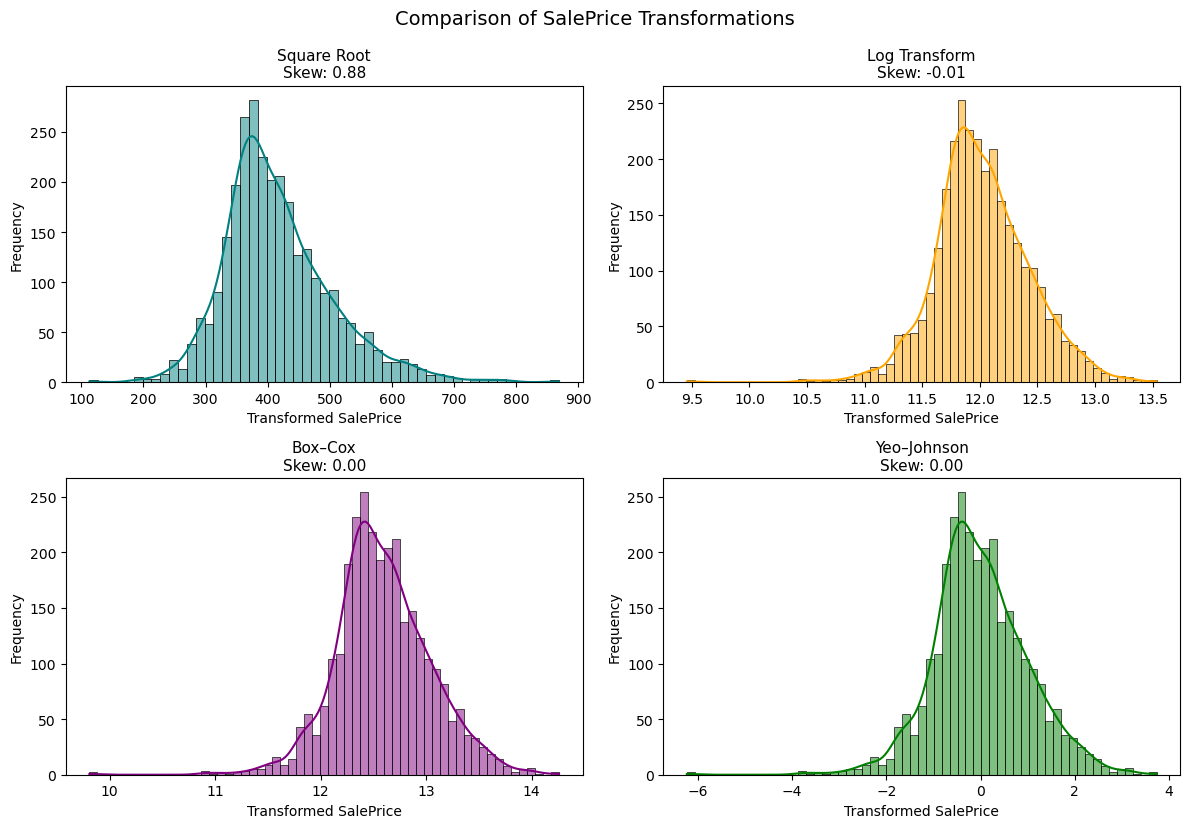

In [52]:
from sklearn.preprocessing import PowerTransformer
from scipy import stats
# Ensure SalePrice is numeric and positive
original['SalePrice'] = pd.to_numeric(original['SalePrice'], errors='coerce')
original = original.dropna(subset=['SalePrice'])
original = original[original['SalePrice'] > 0]

# Apply transformations
original['SqrtSalePrice'] = np.sqrt(original['SalePrice'])
original['LogSalePrice'] = np.log(original['SalePrice'])
original['BoxCoxSalePrice'], _ = stats.boxcox(original['SalePrice'])
pt = PowerTransformer(method='yeo-johnson')
original['YeoJohnsonSalePrice'] = pt.fit_transform(original[['SalePrice']])

# 🎨 Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  # flatten to loop easily

transforms = [
    ('SqrtSalePrice', 'Square Root'),
    ('LogSalePrice', 'Log Transform'),
    ('BoxCoxSalePrice', 'Box–Cox'),
    ('YeoJohnsonSalePrice', 'Yeo–Johnson')
]

colors = ['teal', 'orange', 'purple', 'green']

for ax, (col, title), color in zip(axes, transforms, colors):
    sns.histplot(original[col], kde=True, color=color, ax=ax)
    ax.set_title(f'{title}\nSkew: {original[col].skew():.2f}', fontsize=11)
    ax.set_xlabel('Transformed SalePrice')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Comparison of SalePrice Transformations', fontsize=14, y=1.03)
plt.show()

The histograms show how each transformation affects the distribution of SalePrice.
The original distribution is highly right-skewed, meaning most houses are moderately priced with a few very expensive ones.
After applying transformations:

The Square Root transformation slightly reduces skewness.

The Log transformation makes the distribution much more symmetric.

The Box–Cox and Yeo–Johnson transformations produce nearly normal, bell-shaped curves.

Overall, these transformations help stabilize variance and make the data more suitable for regression modeling, with Log, Box–Cox, and Yeo–Johnson giving the best results.

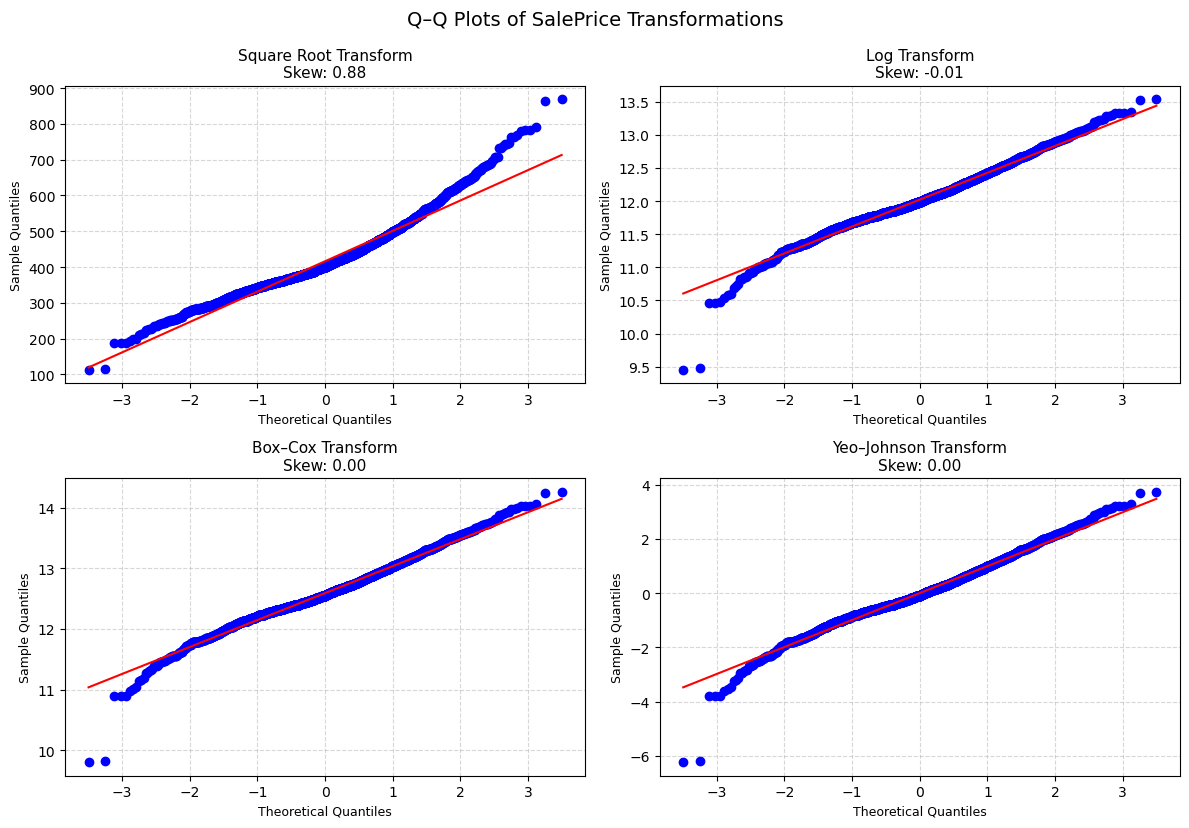

In [53]:
import matplotlib.pyplot as plt
from scipy import stats

#  Make sure these columns exist in your DataFrame
cols = ['SqrtSalePrice', 'LogSalePrice', 'BoxCoxSalePrice', 'YeoJohnsonSalePrice']

# Check that all columns are available
for c in cols:
    if c not in original.columns:
        raise KeyError(f"Column '{c}' not found in your DataFrame. Make sure transformations were run earlier.")

# Create 2×2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Define titles
titles = [
    'Square Root Transform',
    'Log Transform',
    'Box–Cox Transform',
    'Yeo–Johnson Transform'
]

# Loop through each transformation
for ax, col, title in zip(axes, cols, titles):
    # Generate Q–Q plot
    res = stats.probplot(original[col].dropna(), dist="norm", plot=ax)
    
    # Style adjustments
    ax.get_lines()[1].set_color('red')  # make the diagonal line red
    ax.set_title(f"{title}\nSkew: {original[col].skew():.2f}", fontsize=11)
    ax.set_xlabel("Theoretical Quantiles", fontsize=9)
    ax.set_ylabel("Sample Quantiles", fontsize=9)
    ax.grid(True, linestyle="--", alpha=0.5)

# Format the overall layout
plt.tight_layout()
plt.suptitle("Q–Q Plots of SalePrice Transformations", fontsize=14, y=1.03)
plt.show()


The histograms and Q–Q plots revealed that the original SalePrice distribution was strongly right-skewed.

- The Square Root transformation reduced skewness slightly but still left a noticeable tail.

- The Log transformation substantially improved symmetry and aligned most data points along the Q–Q diagonal.

- The Box–Cox and Yeo–Johnson transformations achieved the best normalization, with points closely following the diagonal line in the Q–Q plots, indicating that the transformed data approximate a normal distribution.

**Among these, Box–Cox and Yeo–Johnson performed almost identically. However, because SalePrice contains only positive values and the log transform is simple, interpretable, and widely used in housing price modeling, it was selected for our model.**

### Missing Values:

We notice that there are a lot of missing data in some features from our dataset. Closer inspection to the features with the most missing values, we notice that in fact our parcer is over-zealous and is labelling data as missing where they are not necessarily. For example in `Mas Vrn Type` which labels the masonry veneer type of the property's wall could be actually "None". 

In addition, some features are conditional to the presence of other features. For example `Fireplace Qu` should only be considered as missing if the property actually has a fireplace. 

The same reasoning applies to `Pool QC`,  most properties do not have a pool, so the “missing” values likely represent “No Pool” rather than unavailable data.

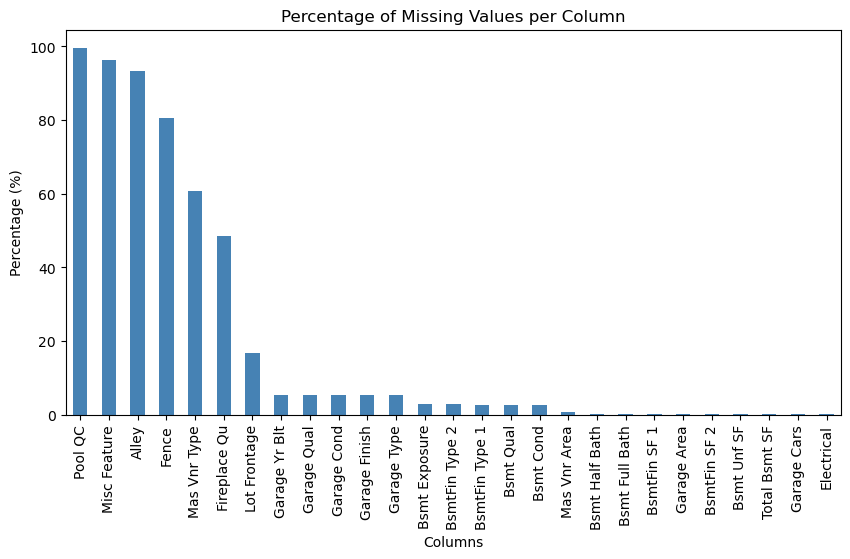

In [55]:
missing_percent.plot(kind='bar', figsize=(10, 5), color='steelblue')
plt.title('Percentage of Missing Values per Column')
plt.ylabel('Percentage (%)')
plt.xlabel('Columns')
plt.show()

# Correlation of Housing features to Sale Price(SalePrice):
In this stage we will explore the relationships between the housing features and the prices that they are sold. By visulizing and computing the correlations, we aim to tackle which attributes(such as year sold,lot area and overall quality) have the highest influence on the target variable SalePrice. A stage that will guide us upon the feature selection for our predictive model.

SalePrice          1.000000
Overall Qual       0.799262
Gr Liv Area        0.706780
2nd Flr SF         0.665128
Garage Cars        0.647877
Total Bsmt SF      0.632414
Garage Area        0.632252
1st Flr SF         0.621676
Full Bath          0.545604
BsmtFin SF 1       0.514500
TotRms AbvGrd      0.495474
Fireplaces         0.474558
Mas Vnr Area       0.441556
Lot Frontage       0.357318
Half Bath          0.285056
Bsmt Full Bath     0.276050
Lot Area           0.266549
BsmtFin SF 2       0.256701
Enclosed Porch     0.227161
Screen Porch       0.173903
Wood Deck SF       0.170550
Bsmt Unf SF        0.144121
Bedroom AbvGr      0.143913
3Ssn Porch         0.087919
Open Porch SF      0.074020
Misc Val          -0.015691
Bsmt Half Bath    -0.035835
Low Qual Fin SF   -0.037660
MS SubClass       -0.085092
Overall Cond      -0.101697
Kitchen AbvGr     -0.119814
Pool Area         -0.300200
Since Remodel     -0.533995
House Age         -0.558983
Name: SalePrice, dtype: float64


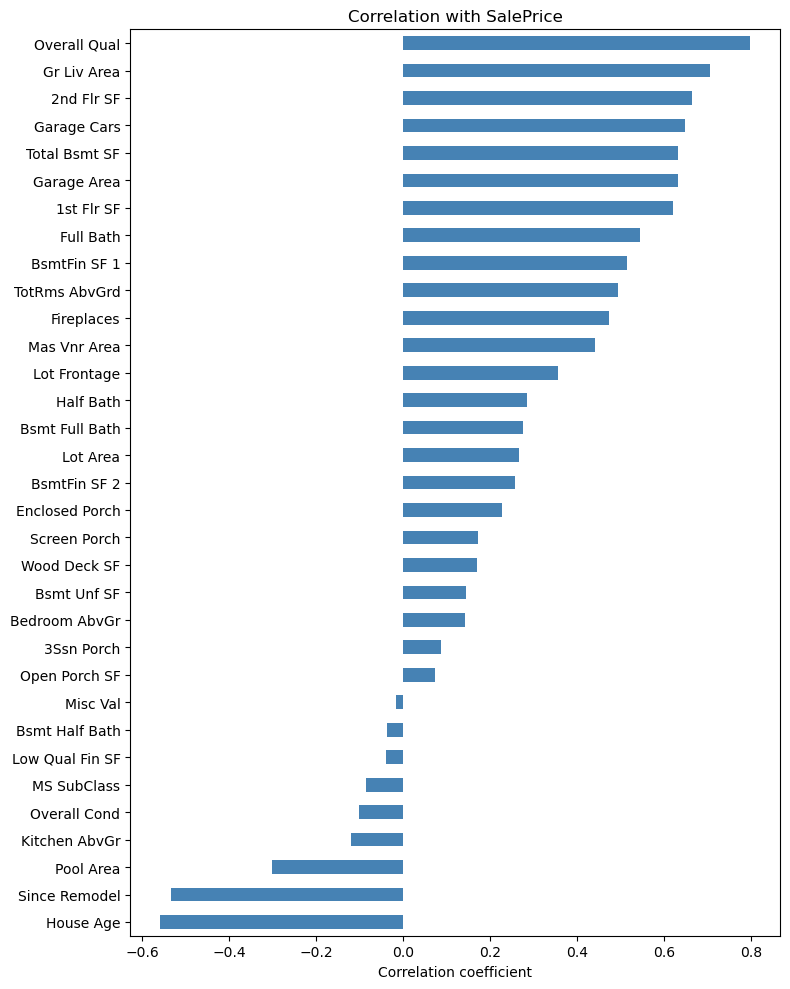

In [56]:
numeric_df = df.select_dtypes(include=[np.number])

corr = numeric_df.corr()

saleprice_corr = corr["SalePrice"].sort_values(ascending=False)

print(saleprice_corr)

plt.figure(figsize=(8, 10))
saleprice_corr.drop("SalePrice").sort_values().plot(kind="barh", color="steelblue")
plt.title("Correlation with SalePrice")
plt.xlabel("Correlation coefficient")
plt.tight_layout()
plt.show()

- Overall Quality (OverallQual) has the strongest positive correlation (~0.8) with SalePrice — meaning houses with better overall material and finish quality tend to sell for higher prices.

- Gr Liv Area (Above-ground living area), Garage Cars, Garage Area, and Total Basement SF also show strong positive relationships, indicating that larger and better-equipped homes are generally more expensive.

- Year Built and Year Remodeled have moderate positive correlations, suggesting that newer or renovated homes tend to be more valuable.

- Features like MS SubClass have weak or slightly negative correlations, implying that they do not contribute much to price prediction or might even indicate cheaper properties.

Overall, the plot clearly highlights which numerical features are most influential in determining house prices, guiding feature selection for modeling tasks such as regression or predictive analysis.

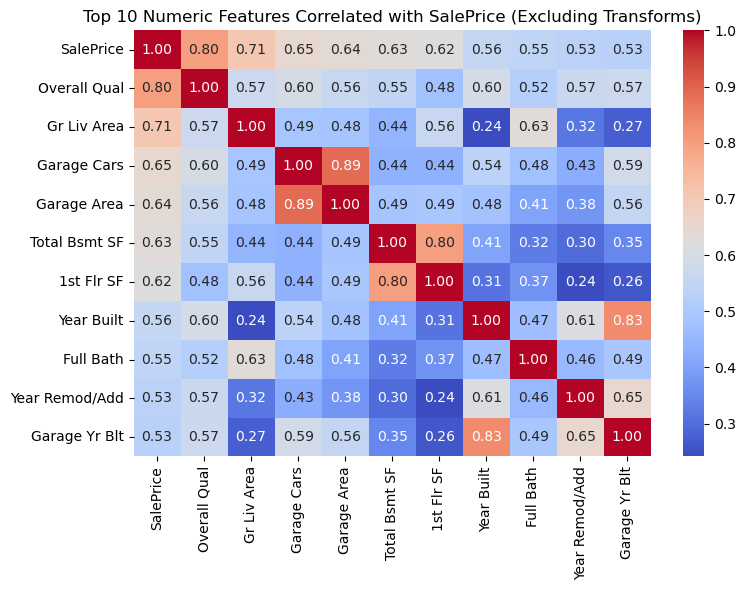

In [57]:
# Compute correlation matrix for numeric columns only
corr = original.corr(numeric_only=True)

# Columns to exclude (transformed SalePrice variants)
exclude_cols = ['SqrtSalePrice', 'LogSalePrice', 'BoxCoxSalePrice', 'YeoJohnsonSalePrice']

# Drop from both rows and columns if they exist
corr_filtered = corr.drop(index=[col for col in exclude_cols if col in corr.index],
                          columns=[col for col in exclude_cols if col in corr.columns],
                          errors='ignore')

# Get top 10 features most correlated with SalePrice (including SalePrice itself)
top_corr = corr_filtered['SalePrice'].sort_values(ascending=False).head(11).index

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(original[top_corr].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Top 10 Numeric Features Correlated with SalePrice (Excluding Transforms)")
plt.tight_layout()
plt.show()

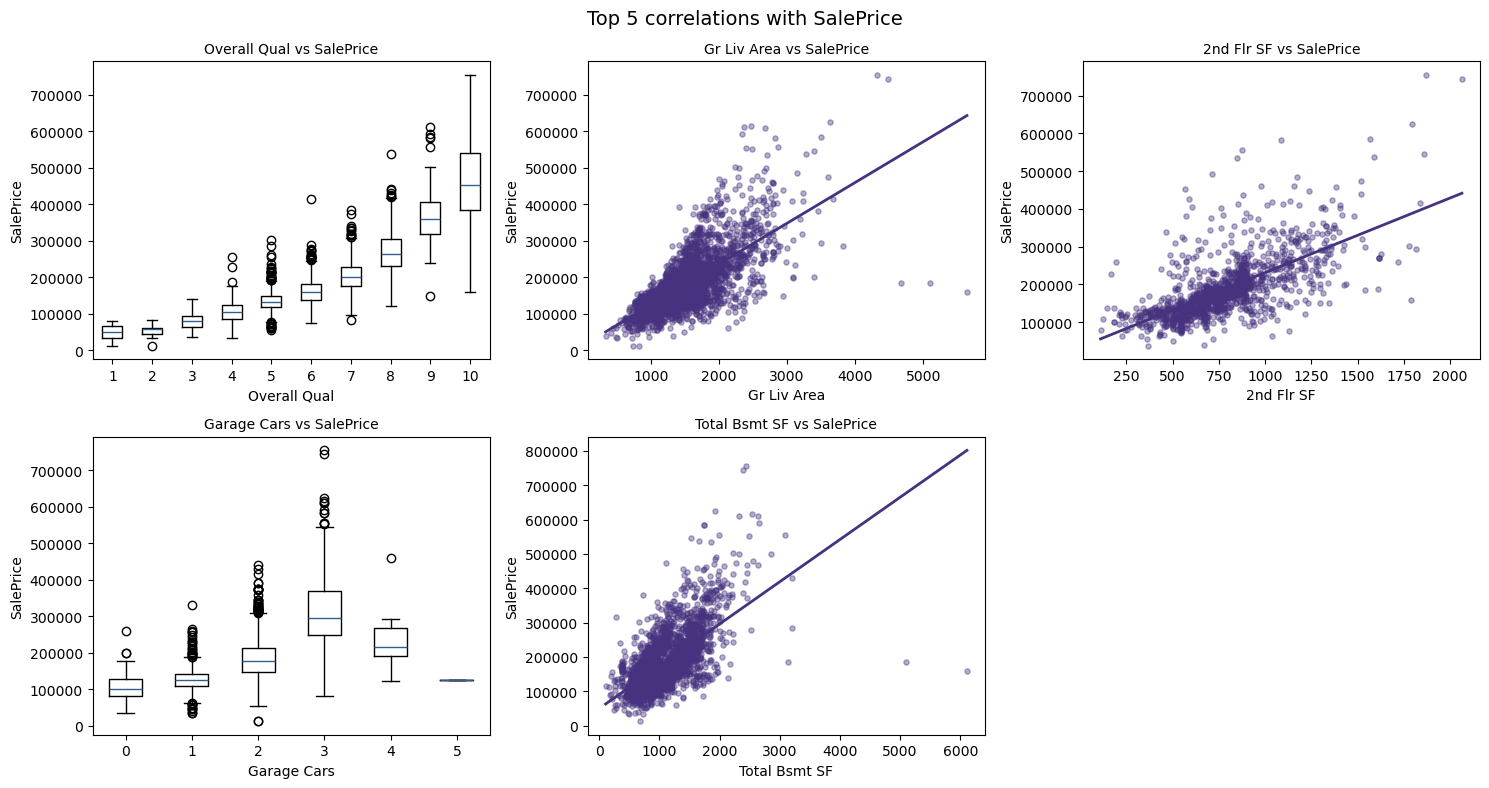

In [58]:
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

saleprice_corr = corr["SalePrice"].dropna()
corr_clean = saleprice_corr.drop([c for c in ["SalePrice", "PID"] if c in saleprice_corr.index])

top5_feats = corr_clean.sort_values(ascending=False).head(5).index.tolist()

def _scatter_or_box(ax, feature):
    s = df[[feature, "SalePrice"]].dropna()
    x = s[feature]
    y = s["SalePrice"]

    if x.nunique() <= 10:
        order = sorted(x.unique())
        groups = [y[x == lvl].values for lvl in order]
        ax.boxplot(groups, tick_labels=[str(o) for o in order], showfliers=True)
        ax.set_xlabel(feature); ax.set_ylabel("SalePrice")
    else:
        xv, yv = x.to_numpy(dtype=float), y.to_numpy(dtype=float)
        ax.scatter(xv, yv, s=14, alpha=0.4)
        if len(xv) > 2:
            k, b = np.polyfit(xv, yv, deg=1)
            xs = np.linspace(np.nanmin(xv), np.nanmax(xv), 200)
            ax.plot(xs, k*xs + b, linewidth=2)
        ax.set_xlabel(feature); ax.set_ylabel("SalePrice")

    r = saleprice_corr.get(feature, np.nan)
    ax.set_title(f"{feature} vs SalePrice", fontsize=10)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()
for i, feat in enumerate(top5_feats):
    _scatter_or_box(axes[i], feat)
for j in range(len(top5_feats), len(axes)):
    axes[j].axis("off")
fig.suptitle("Top 5 correlations with SalePrice", fontsize=14)
plt.tight_layout()
plt.show()

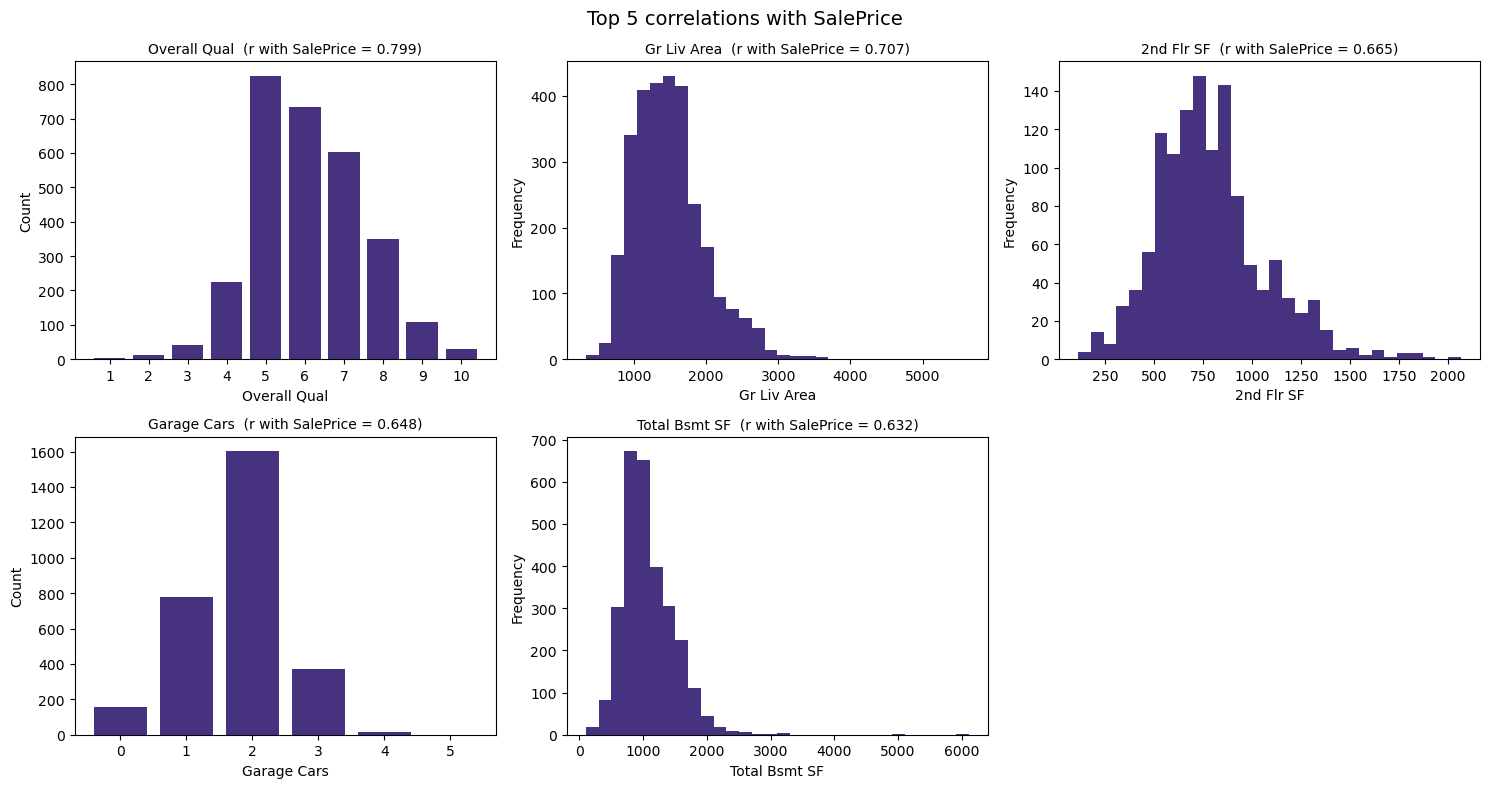

In [59]:
saleprice_corr = corr["SalePrice"].dropna()
corr_clean = saleprice_corr.drop([c for c in ["SalePrice", "PID"] if c in saleprice_corr.index])

top5_feats = corr_clean.sort_values(ascending=False).head(5).index.tolist()

def plot_hist_or_bar(ax, series, feature_name, rvalue):
    """Histogram για συνεχείς μεταβλητές, bar chart για διακριτές."""
    s = series.dropna()
    if s.nunique() <= 10:  # διακριτή
        counts = s.value_counts().sort_index()
        ax.bar([str(k) for k in counts.index], counts.values)
        ax.set_ylabel("Count")
    else:                  # συνεχής
        ax.hist(s.values, bins=30)
        ax.set_ylabel("Frequency")
    ax.set_xlabel(feature_name)
    ax.set_title(f"{feature_name}  (r with SalePrice = {rvalue:.3f})", fontsize=10)

# -------- Top 5: Hist/Bar --------
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()
for i, feat in enumerate(top5_feats):
    r = saleprice_corr.get(feat, np.nan)
    plot_hist_or_bar(axes[i], df[feat], feat, r)
for j in range(len(top5_feats), len(axes)):
    axes[j].axis("off")
fig.suptitle("Top 5 correlations with SalePrice", fontsize=14)
plt.tight_layout()
plt.show()

- Overall Quality:
There’s a clear upward trend — as the Overall Quality rating increases, so does the SalePrice. This confirms that better construction materials and finishes significantly increase home value.

- Gr Liv Area:
A strong positive linear relationship is visible — larger above-ground living areas correspond to higher sale prices. There are a few high-end outliers, but the overall trend is clear.

- Garage Cars:
Homes that can accommodate more cars tend to sell for more. Prices generally rise sharply between 1-car and 3-car garages, then stabilize.

- Garage Area:
Similar to the previous variable, larger garage spaces are associated with higher prices, showing a consistent positive correlation.

- Total Basement SF:
Houses with larger basements tend to sell at higher prices, suggesting that basement size adds to overall livable or usable space value.

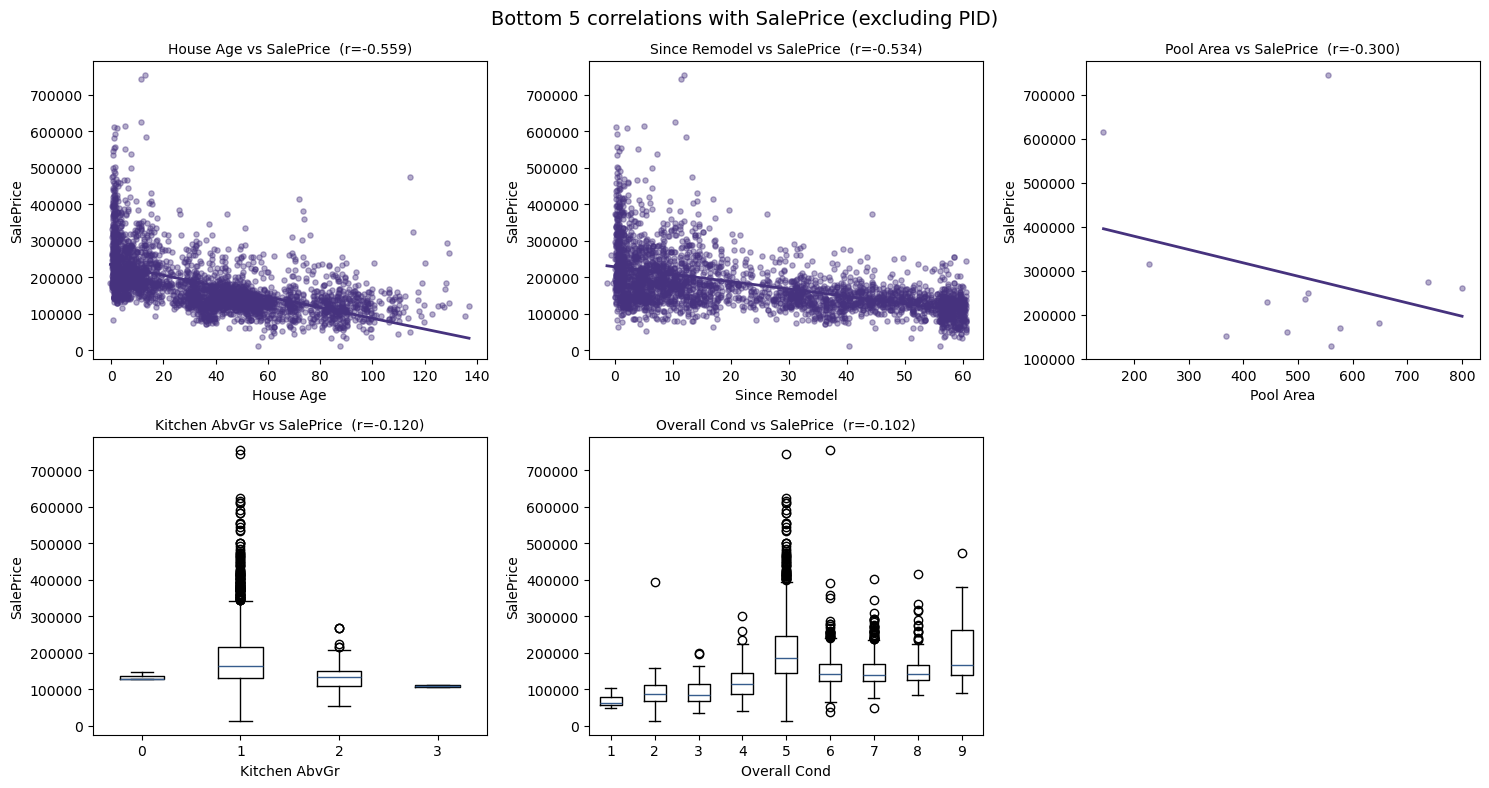

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assumes: df is loaded
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

saleprice_corr = corr["SalePrice"].dropna()
corr_clean = saleprice_corr.drop([c for c in ["SalePrice", "PID"] if c in saleprice_corr.index])

bot5_feats = corr_clean.sort_values(ascending=True).head(5).index.tolist()

def _scatter_or_box(ax, feature):
    s = df[[feature, "SalePrice"]].dropna()
    x = s[feature]
    y = s["SalePrice"]

    if x.nunique() <= 10:
        order = sorted(x.unique())
        groups = [y[x == lvl].values for lvl in order]
        ax.boxplot(groups, tick_labels=[str(o) for o in order], showfliers=True)
        ax.set_xlabel(feature); ax.set_ylabel("SalePrice")
    else:
        xv, yv = x.to_numpy(dtype=float), y.to_numpy(dtype=float)
        ax.scatter(xv, yv, s=14, alpha=0.4)
        if len(xv) > 2:
            k, b = np.polyfit(xv, yv, deg=1)
            xs = np.linspace(np.nanmin(xv), np.nanmax(xv), 200)
            ax.plot(xs, k*xs + b, linewidth=2)
        ax.set_xlabel(feature); ax.set_ylabel("SalePrice")

    r = saleprice_corr.get(feature, np.nan)
    ax.set_title(f"{feature} vs SalePrice  (r={r:.3f})", fontsize=10)

# Plot (Bottom 5)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()
for i, feat in enumerate(bot5_feats):
    _scatter_or_box(axes[i], feat)
for j in range(len(bot5_feats), len(axes)):
    axes[j].axis("off")
fig.suptitle("Bottom 5 correlations with SalePrice (excluding PID)", fontsize=14)
plt.tight_layout()
plt.show()


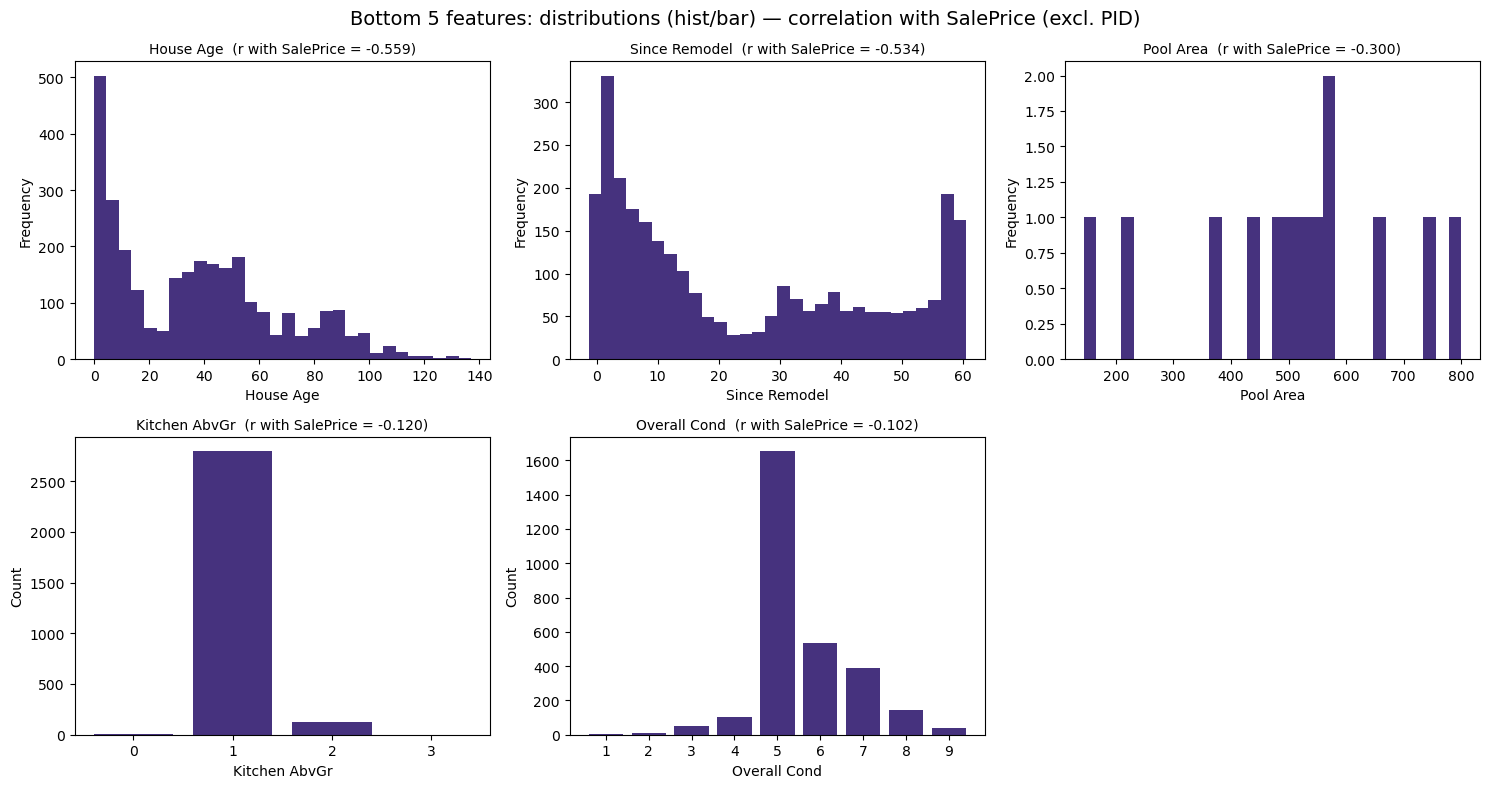

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

saleprice_corr = corr["SalePrice"].dropna()
corr_clean = saleprice_corr.drop([c for c in ["SalePrice", "PID"] if c in saleprice_corr.index])

bot5_feats = corr_clean.sort_values(ascending=True).head(5).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()
for i, feat in enumerate(bot5_feats):
    r = saleprice_corr.get(feat, np.nan)
    plot_hist_or_bar(axes[i], df[feat], feat, r)
for j in range(len(bot5_feats), len(axes)):
    axes[j].axis("off")
fig.suptitle("Bottom 5 features: distributions (hist/bar) — correlation with SalePrice (excl. PID)", fontsize=14)
plt.tight_layout()
plt.show()

- Enclosed Porch:
Shows a weak negative correlation, suggesting that having a larger enclosed porch does not increase house value — in fact, it might slightly decrease it, possibly because enclosed porches are more common in older, less expensive homes.

- Kitchen AbvGr:
Houses with more than one kitchen above ground tend to have lower sale prices, likely reflecting multi-family or less typical homes, which are often less valuable per unit.

- Overall Condition:
Surprisingly, overall condition doesn’t correlate strongly with sale price — this indicates that perceived quality (OverallQual) matters much more than condition scores in determining value.

- MS SubClass:
This feature encodes housing style/type, and its weak negative relationship means that the building classification itself doesn’t drive price — it’s more about quality, size, and location.

- Low Qual Fin SF:
This represents low-quality finished square footage, and its very low correlation confirms that such areas add little or no value to a property.


# Check THIS

## Construction Activity ##

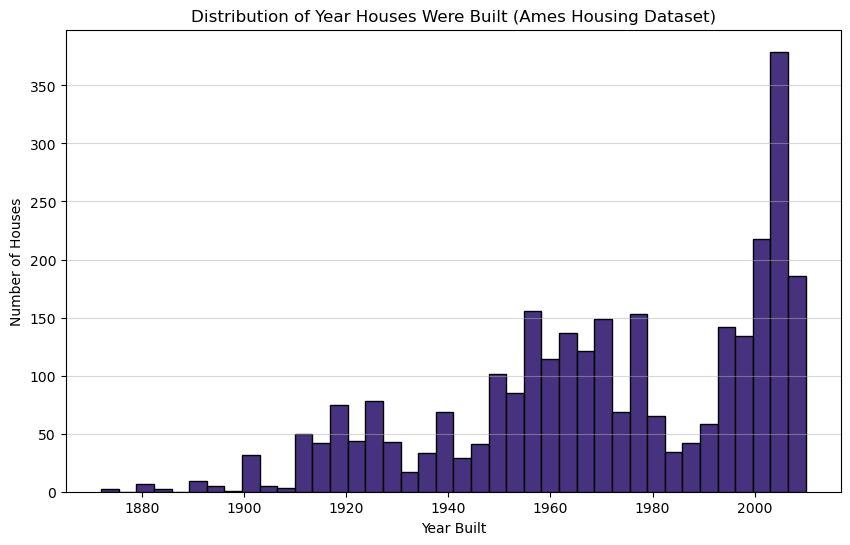

In [62]:
# Plot the distribution of construction years
plt.figure(figsize=(10,6))
plt.hist(df['Year Built'], bins=40, edgecolor='black')
plt.title("Distribution of Year Houses Were Built (Ames Housing Dataset)")
plt.xlabel("Year Built")
plt.ylabel("Number of Houses")
plt.grid(axis='y', alpha=0.5)
plt.show()


The histogram shows the distribution of house construction years in the Ames Housing Dataset. Most houses were built between the mid-1900s and early 2000s, with fewer houses from earlier decades. The plot highlights peaks in construction activity over time.

Text(0.5, 1.0, 'SalePrice vs. Year Built')

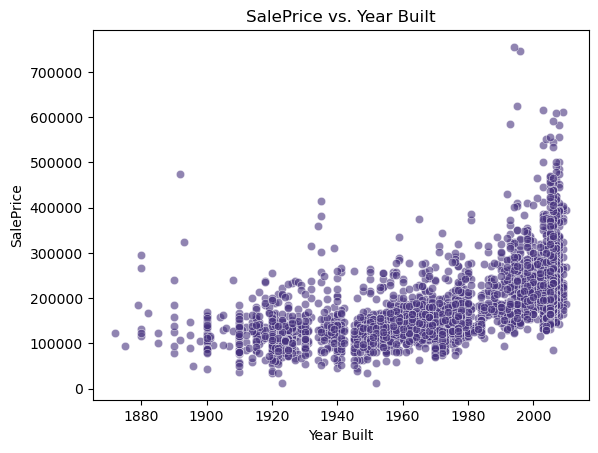

In [63]:
sns.scatterplot(x='Year Built', y='SalePrice', data=df, alpha=0.6)
plt.title("SalePrice vs. Year Built")

This scatter plot displays the relationship between SalePrice and Year Built.
A clear upward trend can be observed — newer houses tend to sell for higher prices, indicating that construction year is an important factor in property value.

Older houses (built before 1950) generally cluster at lower sale prices, while homes built after 1980 show a sharp increase in value. The concentration of higher-priced homes around 2000–2010 suggests that modern constructions and newer materials are more desirable and command higher prices.

Although there is some variation within each period, the overall pattern confirms that house age negatively affects sale price — newer properties are typically more valuable.

Text(0.5, 1.0, 'SalePrice Distribution by Neighborhood')

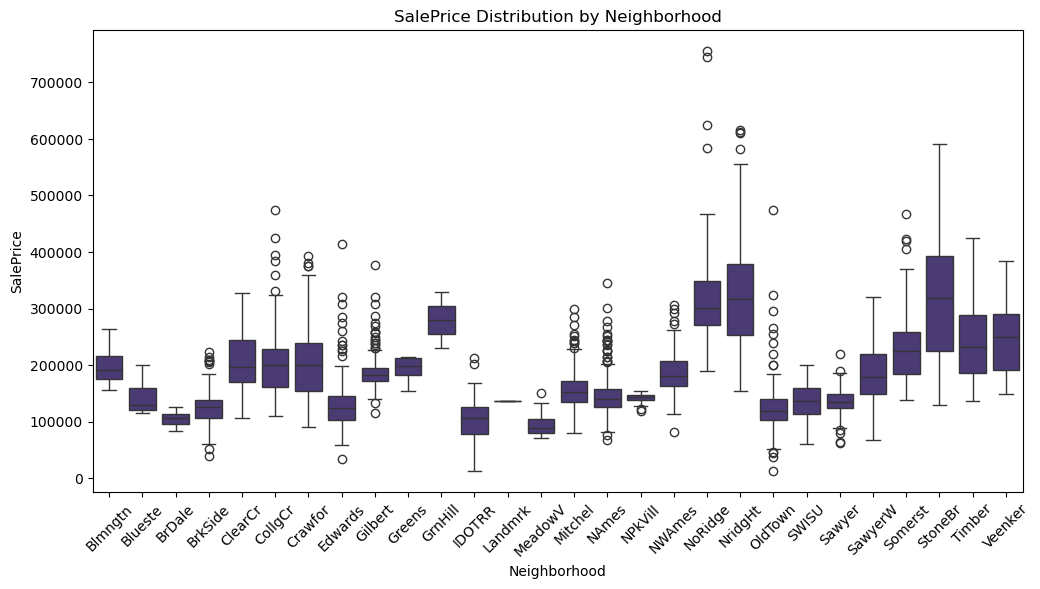

In [64]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=df)
plt.xticks(rotation=45)
plt.title("SalePrice Distribution by Neighborhood")

This boxplot shows the distribution of SalePrice across different neighborhoods in Ames.
The variation in median prices and the spread within each neighborhood clearly illustrate the impact of location on house value.

Neighborhoods such as StoneBr, NridgHt, and NoRidge stand out as premium areas, with significantly higher median sale prices and a wider price range. On the other hand, areas like BrDale, OldTown, and Edwards show lower overall sale prices, indicating more affordable housing markets.

The presence of outliers in many neighborhoods (especially at the high end) suggests that there are individual luxury homes even in otherwise lower-priced areas.
Overall, this plot confirms that location is one of the strongest predictors of property value — consistent with real estate trends in general.

### Distribution of total house sale price
The following visualizations illustrate the monthly distribution of total house sale prices.

The first plot illustrates the total sum of sale prices aggregated by month across all available years. However, it’s important to note that the dataset does not include complete data for the year 2010, meaning that the last year is only partially represented. For this reason, the following two plots focus on the full years 2006–2009, ensuring a more accurate and consistent comparison of monthly sale patterns.

As our instructor suggested, it would be interesting to analyze the data on a daily basis to capture finer temporal fluctuations; unfortunately, the dataset only records sales by month, not by individual date, limiting the granularity of the analysis.

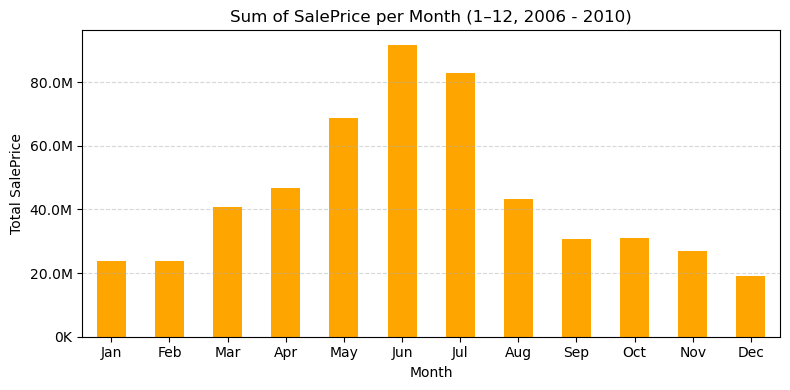

In [68]:
import matplotlib.ticker as mticker

df['Month'] = df['Date Sold'].dt.month

monthly_sum = (
    df.groupby('Month', as_index=True)['SalePrice']
      .sum()
      .reindex(range(1, 13), fill_value=0)
)

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(8, 4))
ax = monthly_sum.plot(kind='bar', color='orange')
plt.title("Sum of SalePrice per Month (1–12, 2006 - 2010)")
plt.xlabel("Month")
plt.ylabel("Total SalePrice")

# Format large numbers as 1M.
ax.yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f'{x/1_000_000:.1f}M' if x >= 1_000_000 else f'{x/1_000:.0f}K'
))

plt.xticks(ticks=range(0, 12), labels=month_labels, rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/var/folders/n6/qwbc3qtx0xv_837m68ghyp3r0000gn/T/ipykernel_7342/2133019701.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_filtered.groupby(['Yr Sold', 'Month'])['SalePrice']


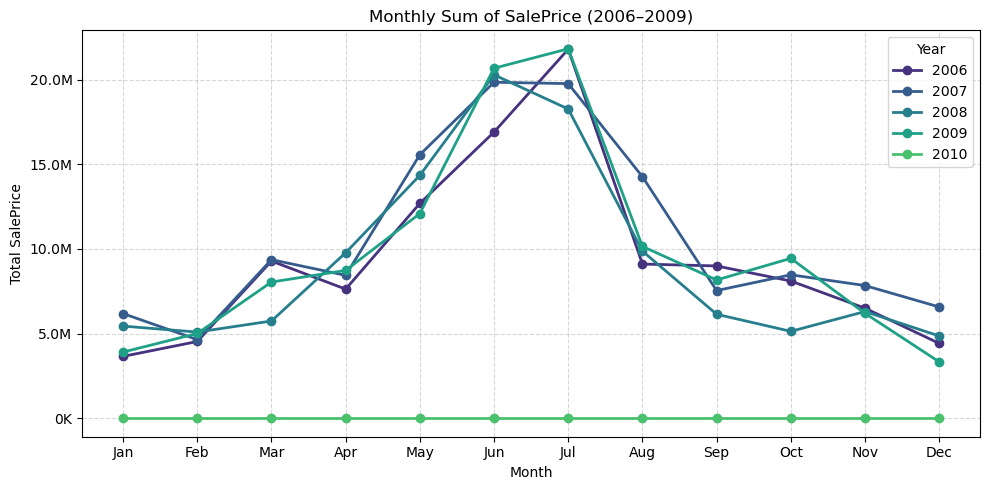

In [73]:
import matplotlib.ticker as mticker

# Filter only full years 2006–2009 (exclude partial 2010)
df_filtered = df[df['Yr Sold'].astype(int).between(2006, 2009)]


# Group by Year + Month
year_month_sum = (
    df_filtered.groupby(['Yr Sold', 'Month'])['SalePrice']
               .sum()
               .unstack(fill_value=0)
)

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot
plt.figure(figsize=(10, 5))
for year in year_month_sum.index:
    plt.plot(range(1, 13), year_month_sum.loc[year], marker='o', linewidth=2, label=str(year))

plt.title("Monthly Sum of SalePrice (2006–2009)")
plt.xlabel("Month")
plt.ylabel("Total SalePrice")

ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f'{x/1_000_000:.1f}M' if x >= 1_000_000 else f'{x/1_000:.0f}K'
))

plt.xticks(range(1, 13), month_labels)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Year")
plt.tight_layout()
plt.show()

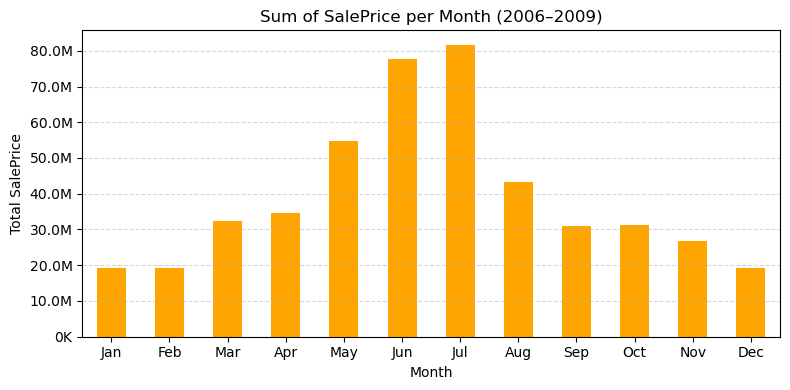

In [77]:
# Keep only data from 2006–2009
df_filtered = df[df['Yr Sold'].astype(int).between(2006, 2009)]

# Compute monthly sum for these years
monthly_sum = (
    df_filtered.groupby('Month', as_index=True)['SalePrice']
      .sum()
      .reindex(range(1, 13), fill_value=0)
)

# Month labels
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(8, 4))
ax = monthly_sum.plot(kind='bar', color='orange')

plt.title("Sum of SalePrice per Month (2006–2009)")
plt.xlabel("Month")
plt.ylabel("Total SalePrice")

# Format Y-axis values as K or M
ax.yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f'{x/1_000_000:.1f}M' if x >= 1_000_000 else f'{x/1_000:.0f}K'
))

plt.xticks(ticks=range(0, 12), labels=month_labels, rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


The two plots above illustrate the monthly distribution of total house sale prices during the period 2006–2009.
In both the line plot and the bar chart, a clear seasonal trend is visible. The total sale price begins at relatively low levels during the winter months (January–February), rises steadily through spring, and reaches its peak during June and July. This pattern suggests that summer is the most active and profitable period for property transactions, while sales decline again through autumn and winter.

The line chart provides additional insight into year-to-year fluctuations, showing that all four years follow a similar seasonal curve, although 2009 appears slightly higher overall in summer months. The bar chart summarizes this behavior by aggregating all years together, confirming that the market consistently peaks mid-year.

## Seasonal Trends of Sales Over Time

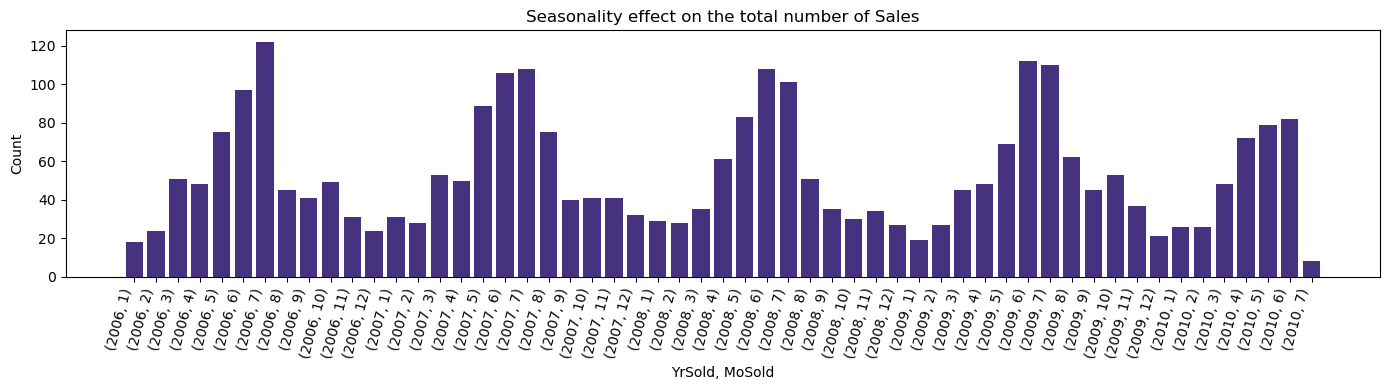

In [78]:
for col in ["Yr Sold", "Mo Sold"]:
    if col not in original.columns:
        raise KeyError(f"Απουσιάζει η στήλη: {col}")

tmp = (
    original[["Yr Sold", "Mo Sold"]]
    .dropna()
    .astype({"Yr Sold": int, "Mo Sold": int})
    .groupby(["Yr Sold", "Mo Sold"])
    .size()
    .reset_index(name="count")
    .sort_values(["Yr Sold", "Mo Sold"])
)
labels = [f"({y}, {m})" for y, m in zip(tmp["Yr Sold"], tmp["Mo Sold"])]

plt.ioff() 
fig = plt.figure(figsize=(14, 4)) 
ax = fig.gca()

x = np.arange(len(tmp))
ax.bar(x, tmp["count"])
ax.set_title("Seasonality effect on the total number of Sales")
ax.set_xlabel("YrSold, MoSold")
ax.set_ylabel("Count")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=75, ha="right")

fig.tight_layout()
plt.show()

### Seasonal Effect Barplot:
The chart indicates a clear seasonal pattern in sales for 2006-2010.Sales consistently peak between May and August and drop sharply between winter months(December to February.

**Possible reasons for this trend:**
- Better weather in spring makes moving easier
- Families prefer to relocate during school holidays
- Reduced demand in winter because of christmas holidays and poor weather

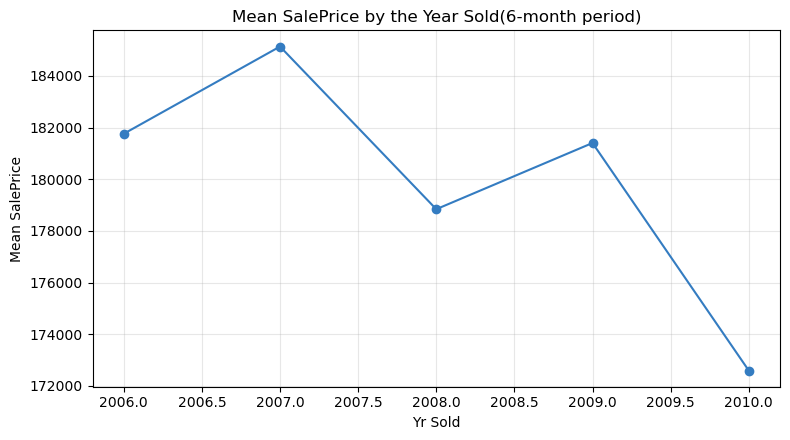

In [79]:
g = (
    original.dropna(subset=["SalePrice", "Yr Sold"])
      .groupby("Yr Sold")["SalePrice"]
      .mean()
      .sort_index()
)

# TODO Also plot mean per month and 6 month

# ---- Plot ----
plt.figure(figsize=(8, 4.5))
plt.plot(g.index.values, g.values, marker="o", color="#347CC1")
plt.title("Mean SalePrice by the Year Sold(6-month period)")
plt.xlabel("Yr Sold")
plt.ylabel("Mean SalePrice")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

###  Expected Seasonal Pattern:
- Prices peaked in 2007, then declined steadily after the 2008 financial crisis.
- Before 2008, strong demand caused clear summer price peaks.
- After 2008, the crisis flattened seasonality and kept prices lower overall.




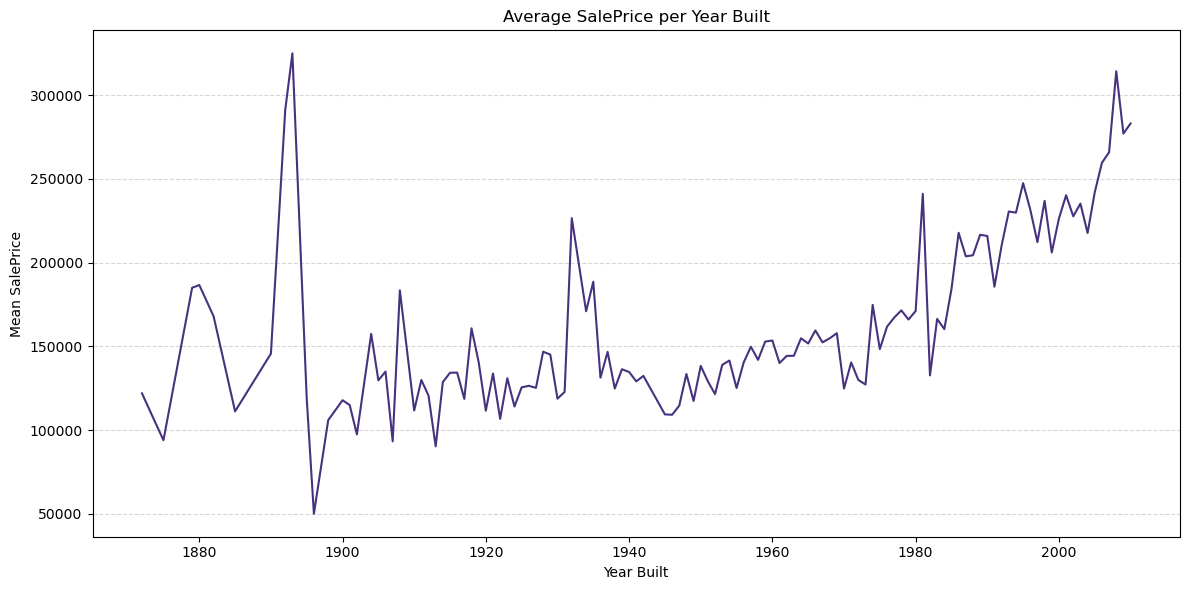

In [80]:
df['YearBuilt_year'] = df['Year Built'].dt.year

# compute mean SalePrice by construction year
yearly_mean = (
    df.groupby('YearBuilt_year', as_index=False)['SalePrice']
      .mean()
      .sort_values('YearBuilt_year')
)

plt.figure(figsize=(12,6))
plt.plot(yearly_mean['YearBuilt_year'], yearly_mean['SalePrice'])
plt.title("Average SalePrice per Year Built")
plt.xlabel("Year Built")
plt.ylabel("Mean SalePrice")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


- The overall trend shows that newer houses tend to sell for higher prices, indicating that modern construction, updated materials, and newer designs increase home value.

- Older properties (pre-1950) generally have lower mean prices and higher variability, likely due to differences in renovation status and historical building conditions.

- After around 1980, prices rise more consistently, with several peaks after 2000 — consistent with increased housing demand and newer neighborhood developments.

- Early spikes (e.g., before 1900) are likely outliers caused by very few historical homes being sold in the dataset.

- The pattern aligns with expectations: house age negatively correlates with price, though location and renovation also play important roles.

## Features Exploration ##

### Pairwise Relationships Between Key Housing Features ###

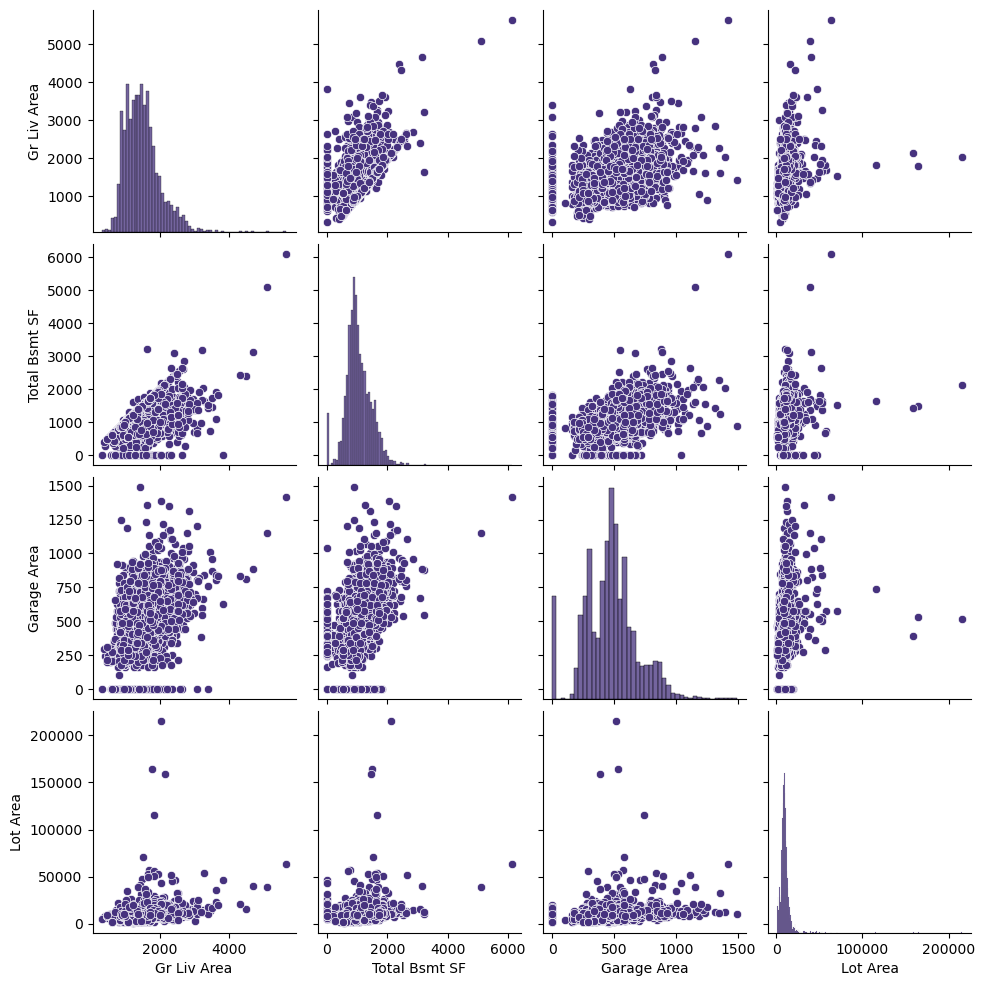

In [81]:
selected_features = ['Gr Liv Area', 'Total Bsmt SF', 'Garage Area', 'Lot Area']
sns.pairplot(original[selected_features])
plt.show()

### Insights from the Pairplot: ###
- GrLivArea and TotalBsmtSF show a positive correlation: larger living areas often have larger basements.
- GrLivArea vs GarageArea shows a weak correlation; bigger houses sometimes have slightly larger garages
- LotArea is mostly independent of house, basement, or garage size.
- Distributions are right-skewed with some outliers in all features.

Comparing it with the average **GarageArea** per **HouseStyle**, we can see that certain house styles tend to cluster around higher or lower garage areas. This highlights how categorical differences (house style) influence the numeric distribution of garage sizes, while also showing overall trends with other features like living area and basement size.

/var/folders/n6/qwbc3qtx0xv_837m68ghyp3r0000gn/T/ipykernel_7342/2621225991.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='House Style', y='Garage Area', data=df, ci=None)


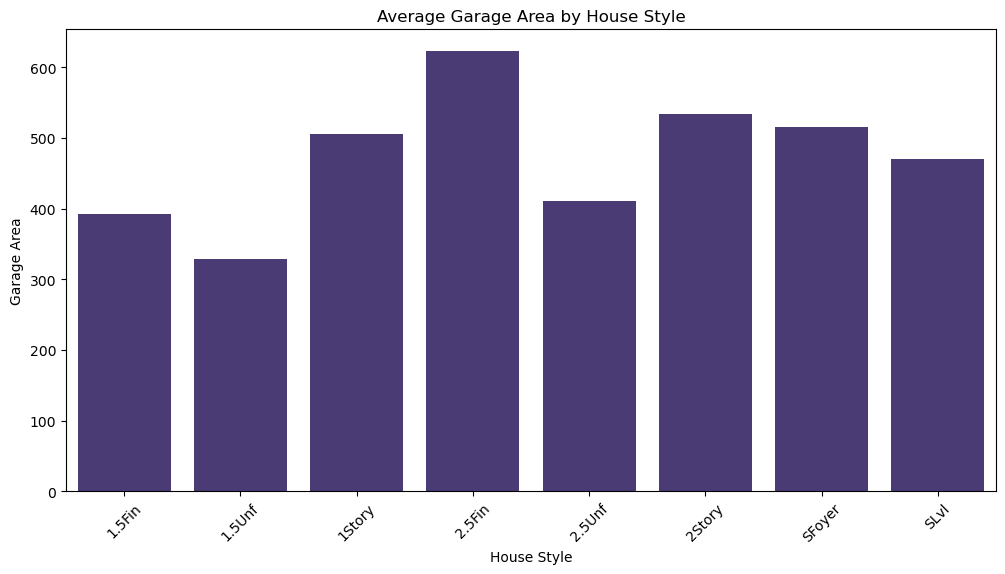

In [82]:
plt.figure(figsize=(12,6))
sns.barplot(x='House Style', y='Garage Area', data=df, ci=None)
plt.xticks(rotation=45)
plt.title("Average Garage Area by House Style")
plt.show()

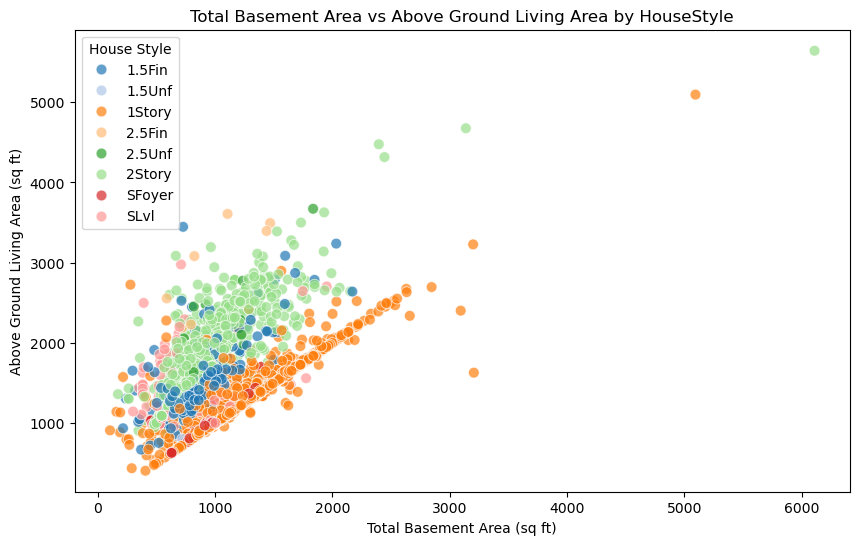

In [83]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Total Bsmt SF', y='Gr Liv Area', hue='House Style', data=df, palette='tab20', s=60, alpha=0.7)
plt.title("Total Basement Area vs Above Ground Living Area by HouseStyle")
plt.xlabel("Total Basement Area (sq ft)")
plt.ylabel("Above Ground Living Area (sq ft)")
plt.show()

**Insights from the Scatterplot:**

_**1.Positive Correlation**_
- Generally, houses with a larger basement area also have a larger above-ground living area.
- This indicates that house size tends to scale both above and below ground.

**2.HouseStyle Clusters** 

- 1Story (orange) is the most frequent and forms a clear linear cluster.
- 2Story (green) houses tend to have larger living areas compared to 1Story for a similar basement size.
- Smaller or specialized styles (SLvl, SFoyer) are clustered at lower areas.

**3.Outliers**

- A few points have extremely large basement or living areas, standing out from the main clusters.
- These could represent luxury homes or data extremes worth noting.

**4.Density**

- Most houses are concentrated at basement < 2000 sq ft and living area < 2500 sq ft, showing typical size ranges.

After examining the relationship between basement and living areas by house style, it’s useful to explore how external property features relate to each other. Plotting Garage Area vs Lot Area by Neighborhood helps reveal how land size influences garage space across different locations, offering insights into neighborhood design patterns and housing density.

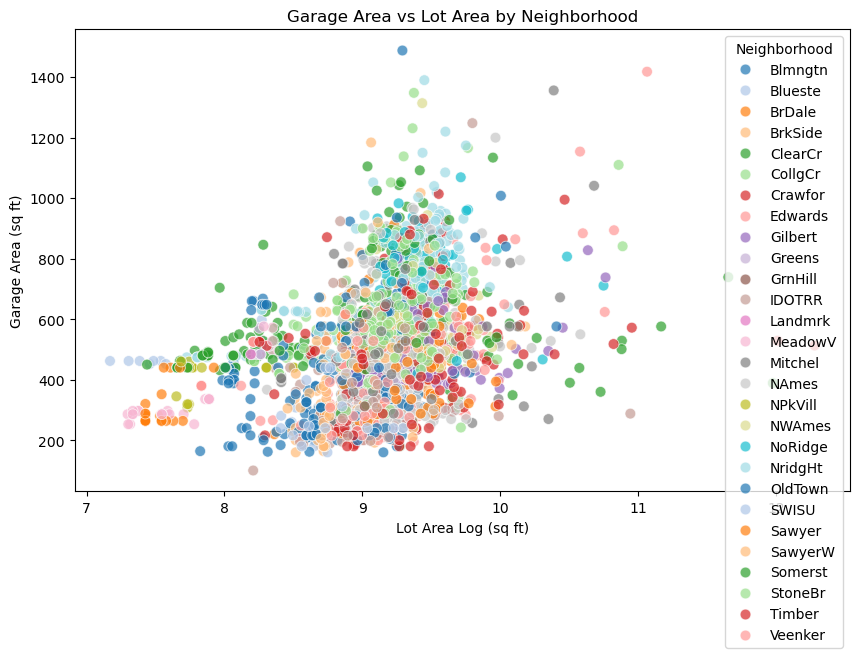

In [84]:
plt.figure(figsize=(10,6))
df['Lot Area Log']=np.log(df['Lot Area'])
sns.scatterplot(x='Lot Area Log', y='Garage Area', hue='Neighborhood', data=df,
                palette='tab20', s=60, alpha=0.7)
plt.title("Garage Area vs Lot Area by Neighborhood")
plt.xlabel("Lot Area Log (sq ft)")
plt.ylabel("Garage Area (sq ft)")
plt.show()

The scatterplot shows a weak positive relationship between lot size and garage area. Most houses, regardless of neighborhood, cluster within smaller lot sizes under 20,000 sq ft. Some neighborhoods, however, extend to larger lots with slightly bigger garages, indicating more spacious suburban layouts. Outliers represent properties with unusually large land areas.

**Garage Area vs Year Built by Overall Quality**

Following the comparison of lot and garage areas across neighborhoods, this graph shifts focus to the evolution of garage space over time, showing whether newer homes tend to include larger garages and how construction quality influences that trend.

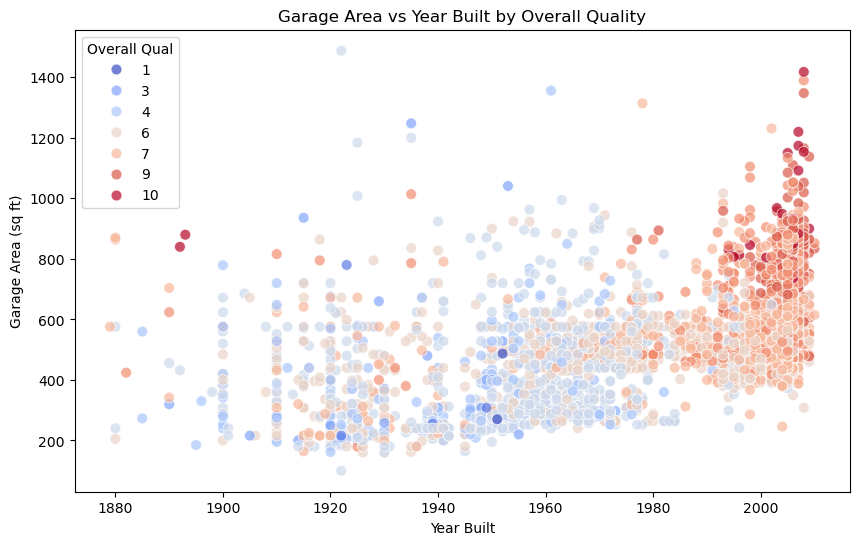

In [85]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Year Built', y='Garage Area', hue='Overall Qual',
                data=df, palette='coolwarm', s=60, alpha=0.7)
plt.title("Garage Area vs Year Built by Overall Quality")
plt.xlabel("Year Built")
plt.ylabel("Garage Area (sq ft)")
plt.show()

**Insight:**
Newer houses generally feature larger garages. Higher-quality homes (in warmer colors) cluster toward both larger garage areas and more recent years, reflecting modern design trends that favor increased vehicle space.

**Average Above Ground Living Area by Year Built**

After exploring garage area trends, it’s valuable to analyze how the size of above-ground living areas has evolved over construction years. This helps identify shifts in housing design and space utilization over time.

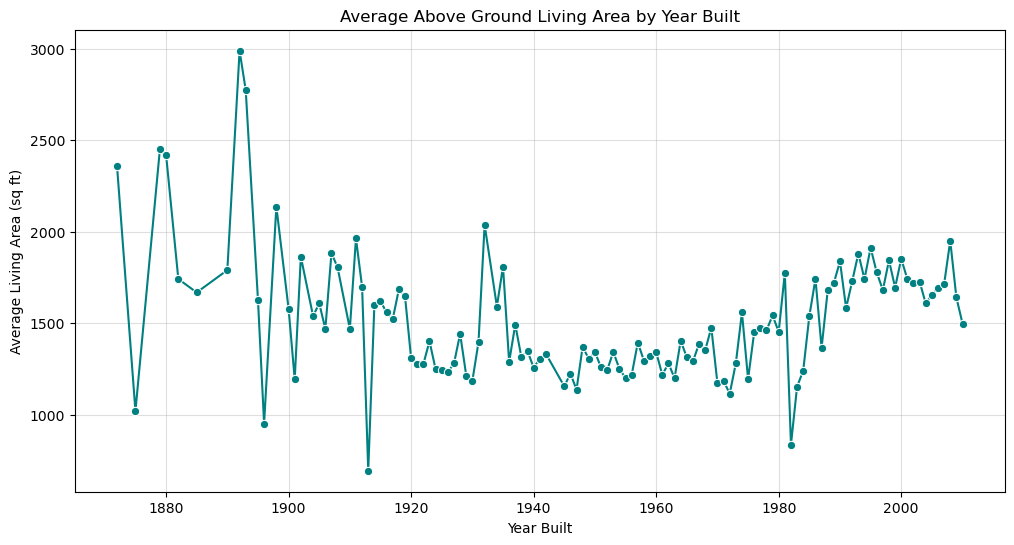

In [86]:
plt.figure(figsize=(12,6))
avg_living = df.groupby('Year Built')['Gr Liv Area'].mean().reset_index()

sns.lineplot(x='Year Built', y='Gr Liv Area', data=avg_living,
             marker='o', color='teal')
plt.title("Average Above Ground Living Area by Year Built")
plt.xlabel("Year Built")
plt.ylabel("Average Living Area (sq ft)")
plt.grid(alpha=0.4)
plt.show()

The average living area fluctuates across years, showing no consistent upward trend. However, there is a noticeable increase in variability after the 1950s, with some periods (like the 1990s–2000s) having slightly larger homes on average. This suggests that house size depends on both the era and design preferences rather than a steady time-based growth.

**Distribution of Total Basement Area by Overall Quality**

After exploring how living area changes over time, it’s insightful to examine how construction quality influences other structural aspects of a house, such as basement size.

/var/folders/n6/qwbc3qtx0xv_837m68ghyp3r0000gn/T/ipykernel_7342/1684029950.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Overall Qual', y='Total Bsmt SF', data=df, palette='coolwarm')


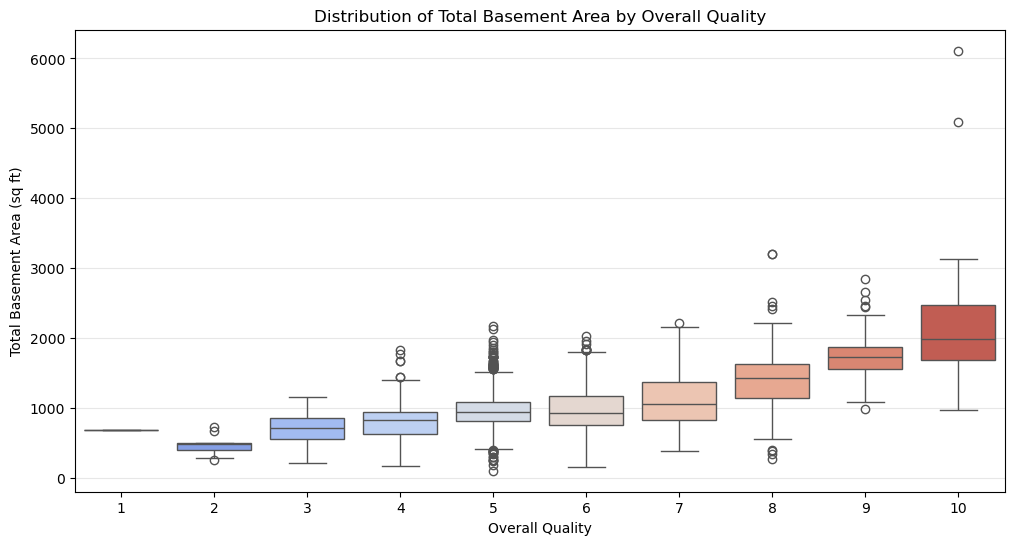

In [87]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Overall Qual', y='Total Bsmt SF', data=df, palette='coolwarm')
plt.title("Distribution of Total Basement Area by Overall Quality")
plt.xlabel("Overall Quality")
plt.ylabel("Total Basement Area (sq ft)")
plt.grid(axis='y', alpha=0.3)
plt.show()

Houses with higher overall quality tend to have larger basements. The boxplot shows a clear upward shift in basement area as quality increases, with a few high-quality homes having exceptionally large basements.

**Count of Houses by House Style**

After analyzing how basement size varies with quality, it’s useful to explore the distribution of house styles to understand which types dominate the dataset.

/var/folders/n6/qwbc3qtx0xv_837m68ghyp3r0000gn/T/ipykernel_7342/4131504502.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='House Style', data=df, palette='tab10', order=df['House Style'].value_counts().index)


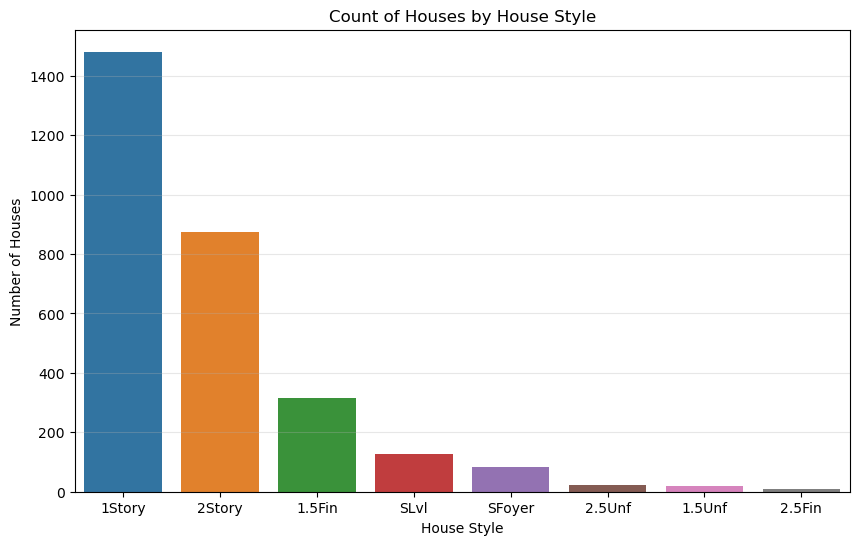

In [88]:
plt.figure(figsize=(10,6))
sns.countplot(x='House Style', data=df, palette='tab10', order=df['House Style'].value_counts().index)
plt.title("Count of Houses by House Style")
plt.xlabel("House Style")
plt.ylabel("Number of Houses")
plt.grid(axis='y', alpha=0.3)
plt.show()


One-story houses are the most common, followed by two-story homes. Split-level and other specialized styles appear less frequently, indicating that single-story designs dominate the Ames housing market.

**Number of Houses Built per Decade**

To understand how construction activity has changed over time, this plot shows the number of houses built in each decade, highlighting development trends in Ames.

/var/folders/n6/qwbc3qtx0xv_837m68ghyp3r0000gn/T/ipykernel_7342/3516779229.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=decade_counts.index, y=decade_counts.values, palette='mako')


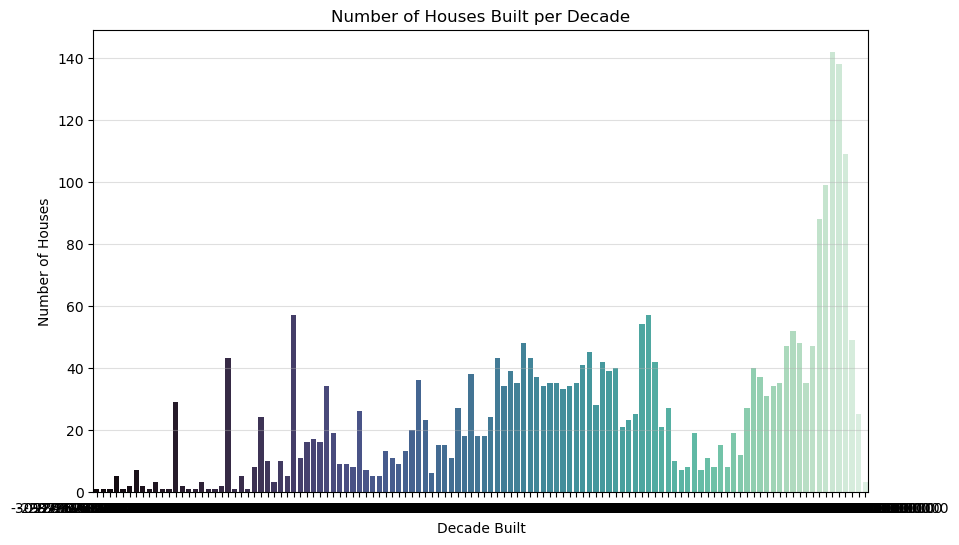

In [89]:
# Make sure YearBuilt_year is integer
df['Year Built'] = df['Year Built'].astype(int)

# Create a decade column
df['DecadeBuilt'] = (df['Year Built'] // 10) * 10

# Count houses by decade
decade_counts = df['DecadeBuilt'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=decade_counts.index, y=decade_counts.values, palette='mako')
plt.title("Number of Houses Built per Decade")
plt.xlabel("Decade Built")
plt.ylabel("Number of Houses")
plt.grid(axis='y', alpha=0.4)
plt.show()

The number of houses built increased significantly between the 1950s and 2000s, reflecting periods of urban expansion. A slight decline appears in the most recent decade, likely due to limited new development.

**Exterior Quality Over Decade**

After examining construction trends and quality, this visualization connects exterior material quality to the decade of construction, showing how design and material choices evolved over time.

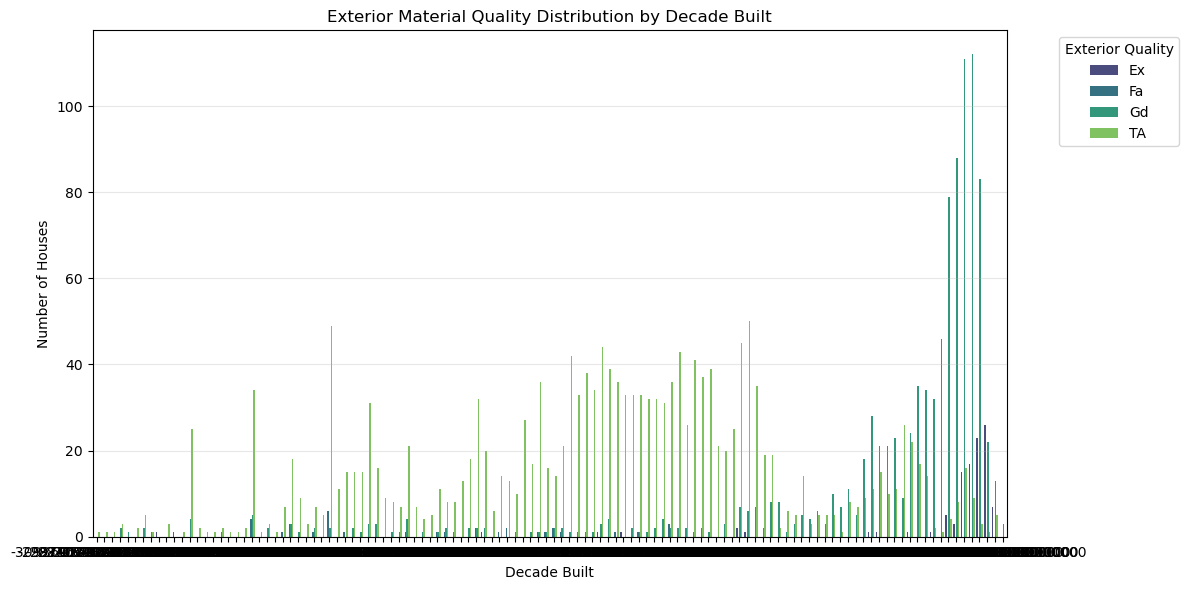

In [90]:
plt.figure(figsize=(12,6))
sns.countplot(x='DecadeBuilt', hue='Exter Qual', data=df, palette='viridis')
plt.title("Exterior Material Quality Distribution by Decade Built")
plt.xlabel("Decade Built")
plt.ylabel("Number of Houses")
plt.legend(title='Exterior Quality', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Older homes show a mix of lower exterior quality ratings, while newer houses (post-1990) lean toward higher-quality materials, reflecting improved construction standards and modern building preferences.

**Yearly Trend of Roof Styles (Stacked Area Plot)**

To visualize how architectural designs evolved over time, this stacked area plot shows the yearly proportion of roof styles in the Ames housing data


/var/folders/n6/qwbc3qtx0xv_837m68ghyp3r0000gn/T/ipykernel_7342/3314559817.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  roof_trend = df.groupby(['Year Built', 'Roof Style']).size().unstack(fill_value=0)


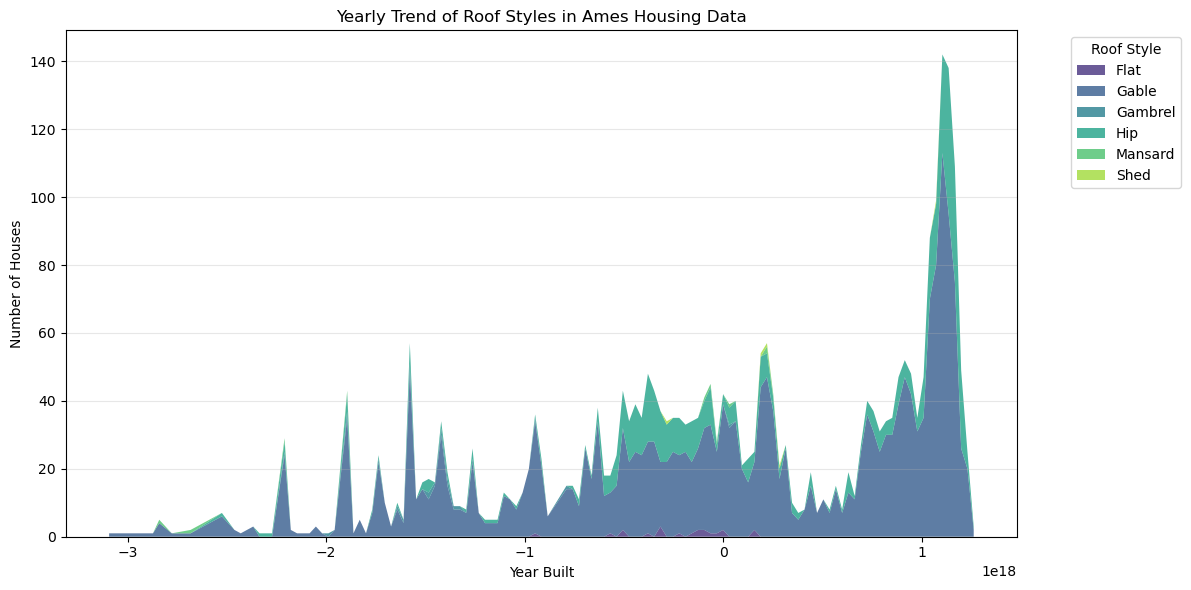

In [91]:
# Group by YearBuilt_year and RoofStyle
roof_trend = df.groupby(['Year Built', 'Roof Style']).size().unstack(fill_value=0)

# Create a stacked area plot
plt.figure(figsize=(12,6))
plt.stackplot(roof_trend.index, roof_trend.T, labels=roof_trend.columns, alpha=0.8)

plt.title("Yearly Trend of Roof Styles in Ames Housing Data")
plt.xlabel("Year Built")
plt.ylabel("Number of Houses")
plt.legend(title='Roof Style', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Gable roofs consistently dominate across all years, but hip roofs gradually increase in share over time, especially after 1980, suggesting a shift toward more modern and weather-resistant architectural designs.

The exploratory data analysis provided a comprehensive understanding of the Ames Housing dataset beyond price trends. By examining structural, temporal, and design-related features, several patterns emerged: larger homes tend to have proportionally larger basements and garages, construction activity peaked between the 1950s and 2000s, and newer houses generally display higher overall quality. Design-focused exploration revealed gradual improvements in exterior materials and a clear shift in roof styles over time, reflecting evolving architectural preferences.

With these insights, the dataset is now well-understood in terms of feature behavior, relationships, and potential multicollinearity. The next step involves data preprocessing — handling missing values, scaling numeric features, and encoding categorical variables — to prepare for predictive modeling and feature importance analysis.

### Post-EDA Missing-Value Strategy
After completing EDA, we finalized a pragmatic imputation plan. We first removed helper/derived date fields that are no longer needed in modeling (Date Sold, Garage Yr Blt, Year Built, Year Remod/Add). We then dropped columns with excessive missingness that would add noise or require heavy assumptions (Fireplace Qu, Mas Vnr Type, Fence, Bsmt Exposure, Alley, Misc Feature, Pool QC). For garage-related indicators we filled missing values with 0 to explicitly encode “no/none/not present” for downstream models (Garage Qual, Garage Type, Garage Cond). For the remaining set, we applied type-aware imputation: numeric columns were filled with their mean, while categorical/text columns were filled with their mode (most frequent value). Finally, we verified the shape change and confirmed no remaining NAs in the targeted columns.

In [96]:
df = df.drop(columns=[
    'Date Sold',
    'Garage Yr Blt',
    'Year Built',
    'Year Remod/Add',
    'Fireplace Qu',
    'Mas Vnr Type',
    'Fence',
    'Bsmt Exposure',
    'Alley',
    'Misc Feature',
    'Pool QC'
])
df.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Area',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Type',
       'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF',
    

In [102]:
# Fill missing garage-related categorical values with 'None'
# Clean column names (just in case) 
df.columns = df.columns.str.strip()

garage_cat = [c for c in ['Garage Qual', 'Garage Type', 'Garage Cond'] if c in df.columns]

df[garage_cat] = df[garage_cat].astype('string').fillna('None')

print(df[garage_cat].isna().sum())

# Already done with none?

Garage Qual    0
Garage Type    0
Garage Cond    0
dtype: int64


In [111]:
import pandas as pd
import numpy as np

cols_to_fill = [
    'Lot Frontage','Total Bsmt SF','Bsmt Unf SF','BsmtFin SF 2',
    'Electrical',                # categorical
    'BsmtFin SF 1','Garage Area','Garage Cars',
    'Bsmt Full Bath','Bsmt Half Bath','Mas Vnr Area',
    'Bsmt Qual','Bsmt Cond','BsmtFin Type 1','BsmtFin Type 2'
]

treated = {"int": [], "float": [], "cat": []}

for col in cols_to_fill:
    if col not in df.columns:
        continue

    s = df[col]

    # ---- categorical / object-like (also covers 'Electrical') ----
    if pd.api.types.is_object_dtype(s) or pd.api.types.is_categorical_dtype(s) or s.dtype == "string":
        mode = s.mode(dropna=True)
        df[col] = s.fillna(mode.iloc[0] if not mode.empty else "None")
        treated["cat"].append(col)

    # ---- integer-like (nullable Int64 etc.) ----
    elif pd.api.types.is_integer_dtype(s):
        # use median, keep integer dtype (round just in case)
        med = pd.to_numeric(s, errors="coerce").mean()
        df[col] = pd.to_numeric(s, errors="coerce").fillna(med).round().astype("Int64")
        treated["int"].append(col)

    # ---- float-like ----
    else:
        mean = pd.to_numeric(s, errors="coerce").mean()
        df[col] = pd.to_numeric(s, errors="coerce").fillna(mean)
        treated["float"].append(col)

print("Filled as integers:", treated["int"])
print("Filled as floats:", treated["float"])
print("Filled as categoricals:", treated["cat"])
print(df[cols_to_fill].isna().sum())
df

Filled as integers: ['Garage Cars', 'Bsmt Full Bath', 'Bsmt Half Bath']
Filled as floats: ['Lot Frontage', 'Total Bsmt SF', 'Bsmt Unf SF', 'BsmtFin SF 2', 'BsmtFin SF 1', 'Garage Area', 'Mas Vnr Area']
Filled as categoricals: ['Electrical', 'Bsmt Qual', 'Bsmt Cond', 'BsmtFin Type 1', 'BsmtFin Type 2']
Lot Frontage      0
Total Bsmt SF     0
Bsmt Unf SF       0
BsmtFin SF 2      0
Electrical        0
BsmtFin SF 1      0
Garage Area       0
Garage Cars       0
Bsmt Full Bath    0
Bsmt Half Bath    0
Mas Vnr Area      0
Bsmt Qual         0
Bsmt Cond         0
BsmtFin Type 1    0
BsmtFin Type 2    0
dtype: int64


/var/folders/n6/qwbc3qtx0xv_837m68ghyp3r0000gn/T/ipykernel_7342/2464450967.py:21: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(s) or pd.api.types.is_categorical_dtype(s) or s.dtype == "string":


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Yr Sold,Sale Type,Sale Condition,SalePrice,House Age,Since Remodel,Month,YearBuilt_year,Lot Area Log,DecadeBuilt
PID,,,,,,,,,,,,,,,,,,,,,
526301100,20,RL,141.00000,31770.0,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,2010,WD,Normal,215000,50.4,50.4,5,1960,10.366278,-315619200000000000
526350040,20,RH,80.00000,11622.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,2010,WD,Normal,105000,49.4,49.4,6,1961,9.360655,-283996800000000000
526351010,20,RL,81.00000,14267.0,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,2010,WD,Normal,172000,52.4,52.4,6,1958,9.565704,-378691200000000000
526353030,20,RL,93.00000,11160.0,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,2010,WD,Normal,244000,42.3,42.3,4,1968,9.320091,-63158400000000000
527105010,60,RL,74.00000,13830.0,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,2010,WD,Normal,189900,13.2,12.2,3,1997,9.534595,852076800000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923275080,80,RL,37.00000,7937.0,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,2006,WD,Normal,142500,22.2,22.2,3,1984,8.979291,441763200000000000
923276100,20,RL,69.22459,8885.0,Pave,IR1,Low,AllPub,Inside,Mod,...,2006,WD,Normal,131000,23.4,23.4,6,1983,9.092120,410227200000000000
923400125,85,RL,62.00000,10441.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,2006,WD,Normal,132000,14.5,14.5,7,1992,9.253496,694224000000000000


## Data Preprocessing

In the previous sections we have visualized the dataset, removed inconsistencies, casted data to correct types and got a feel of the distribution and the representation each feature has in the dataset.

This section will prepare the data for the machine learning models to use. In particular we will:

- Split the dataset to train and test.
- Encode categorical features, both nomial and ordinal
- Perform feature scaling so that distance based methods like the Lasso and KNN will not give more weight to features with larger magnitude 
- Standardize numerical features by centering around mean 0 and unit variance to ensure all features contributed equally to the regression model and to improve numerical stability
- Transformation target variable to a more gaussian like shape, as normality helps linear regression and tree-based models.                                                                 
- Perform dimensionality reduction with feature selection and feature extraction. We want to remove variables exhibiting high multicollinearity, and variables which do not significanlty contribute to the model, while keeping features with high predictive power. This can be done with domain knowledge or with statistical techniques. A lower dimensional dataset containing strong predictors allows models to converge faster and achieve better results with a smaller amount of data.
- Imputing dataset to fill missing data. We have shown that our dataset has little to none missing data, so we only need to introduce a `None` type to the appropriate categorical data.
- No need to handle imbalanced Data since we are regressing a continuous variable.


In [39]:
# Take a note of the numerical and categorical data
df_clean = df.copy()

numerical = [col for col in df_clean.select_dtypes(include=['int64', 'float64']).columns if col != 'SalePrice']
categorical = [col for col in df_clean.select_dtypes(include=['category']).columns]
ordinal = [col for col in categorical if df_clean[col].dtype.ordered]
nominal = [col for col in categorical if not df_clean[col].dtype.ordered]

### Feature Encoding

There are many different ways to encode our feaatures. Using the simply `LabelEncoder` gives a numerical reprecentation of the category for our models like Linear Regression to use. However distance based models might erronuously make conclusions about the difference betweeen them. For example using a `red: 1, green: 2, blue:3` encoding might mistakenly lead to conclusions that blue is 2 units better than red.

Similarly, using `OneHotEncoder`, which creates dummy variable for each category, to address this issue, increases the dimensionality of the dataset significantly which makes our model more computationally expensive and suffering from the curse of dimensionality. There is no need to use it when we have a binary feature, i.e. with only 2 possible values.

To cater to the idiosyncrasies of the different models, we will create various dataset to satisfy each particular one.

In [46]:
df_encoded = df_clean.copy() # We do this in case we want to re-run from this point onwards

# TODO: This could have been in a pipeline

encode_ordinally = [col for col in df_clean.select_dtypes(include=['category']) if df_clean[col].dtype.ordered or df_clean[col].dtype.categories.size <= 2]
encode_onehotly = [col for col in df_clean.select_dtypes(include=['category']) if not df_clean[col].dtype.ordered and not df_clean[col].dtype.categories.size <= 2]

ordinal_encoder = ce.OrdinalEncoder(cols=encode_ordinally)
df_encoded = ordinal_encoder.fit_transform(df_encoded)

onehot_encoder = ce.OneHotEncoder(cols=encode_onehotly, use_cat_names=True)
df_encoded = onehot_encoder.fit_transform(df_encoded)

ordinally_encoded = encode_ordinally
onehot_encoded = [col for col in df_encoded.columns  if any(col.startswith(f'{p}_') for p in encode_onehotly) ]

df_encoded = df_encoded[[*numerical, *ordinally_encoded, *onehot_encoded]]

### Train and Test split

In order to validate our models we will take out a portion of our data to use for testing our models. We will make an 90 : 10 split. Later depending on the analysis we want to perform, we will either split the train data for validation purposes using simple splits, k-folds, or other techniques.

Fitting scaling, normalizations or dimensionality reduction techniques should **only** be done in our training dataset, as using the whole dataset will accidentally "leak" information about the test dataset and over-estimate the performance of our models

In [48]:
# Re-running train_test_split only works because we set `random_state`.
df_train, df_test = train_test_split(df_clean, train_size=0.9, random_state=42)
df_encoded_train, df_encoded_test = train_test_split(df_encoded, train_size=0.9, random_state=42)

### Feature Scaling:

#### Should we scale the features?

When to scale:
- Encoded feature has many levels → prevents it from dominating
- Ordinal encoding with meaningful, evenly spaced values (e.g., 1-5 survey
ratings) → can use scaling that preserves relationships (e.g. MinMax scaling)

When not to scale:
- Purely categorical / arbitrary values (e.g., education levels 1-3, colors 0-2)
- Scaling such values (getting them closer or further) can imply a relationship
that doesn’t exist
- Features being one-hot-encoded
- Binary categories

#### Should we normalize target variable?

Usually not required, but can help in regression tasks

When to scale:
- Target has a wide value range (e.g., income in hundreds to millions) → prevents large values from dominating
- Using gradient descent-based models (e.g., linear regression) → speeds up
convergence

#### Available Scalers

- Normalization (MinMaxScaler):
  + Works best for features with different ranges and few or no significant outliers
- Standardization (StandardScaler):
  + Works well for features with approximately normal distributions and few/no influential outliers
- Robust Scaling (RobustScaler):
  + Best for features with many outliers or skewed (long-tailed) distributions



In [64]:
# We use a column transformer (used also in Big Data course in pyspark) to build the pipeline that both encodes and scales
# CURRENTLY NOT USED

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal',
             make_pipeline(
                 ce.OrdinalEncoder(cols=ordinal),
                 MinMaxScaler(feature_range=(0, 1)),
        ), ordinal),
        ('nominal', ce.OneHotEncoder(cols=nominal, use_cat_names=True), nominal),
        ('numerical', RobustScaler(), numerical),
    ]
)

X_train = preprocessor.fit_transform(df_train.drop(columns=['SalePrice']))
y_train = df_train[['SalePrice']]
X_test = preprocessor.transform(df_test.drop(columns=['SalePrice']))
y_test = df_test[['SalePrice']]

## Feature Selection and Extraction

Our dataset has relatively many features. Working with many features leads to some models such as the k-neighbors regresssor, perform poorer. This is often refered to as the curse of dimensionality. Furthermore, many of our features are correlated with each other, meaning we have colinearity problems.

We will investigate two different techniques. One is to select a subset of the existing features that do sufficiently good job explaining the target variable behavior, and the other is to project the existing features to a smaller dimensionality space thus extracting new ones that explain the the model. The former family is known as "feature selection" 

### Feature Selection

We will use:

- Forward Selection
- Backward Selection
- Using the Lasso model

In [ ]:
# Do it in a package to get a pretty plot
# Forward Selection
# Do not run this - we want to use the mlxtend one

sfs_forward = SequentialFeatureSelector(
    estimator=LinearRegression(),
    n_features_to_select=10,
    direction='forward',
    scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

X_train = df_encoded_train.fillna(0)
y_train = df_train['SalePrice']
# sfs.fit_transform(X_train, y_train) # Skip this - do this with the other library

In [ ]:
# Do not run this - we want to use the mlxtend one
# X_train.columns[sfs_forward.get_support()]

In [73]:
# Do it in a package to get a pretty plot
# Forward Selection
# This takes a lot of time
# See https://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

X_train = df_encoded_train.fillna(0)
y_train = df_train['SalePrice']

sfs_forward = SFS(LinearRegression(),
          k_features='best',
          forward=True,
          scoring='r2',
          cv=5)
sfs_forward = sfs_forward.fit(X_train, y_train)

In [75]:
print(f'Selected features:', sfs_forward.k_feature_names_)

Selected features: ('MS SubClass_90.0', 'MS SubClass_45.0', 'MS SubClass_70.0', 'MS SubClass_150.0', 'MS Zoning_RH', 'MS Zoning_RM', 'Lot Area', 'Street', 'Lot Shape', 'Land Contour_HLS', 'Land Contour_Bnk', 'Lot Config_Inside', 'Lot Config_CulDSac', 'Neighborhood_Gilbert', 'Neighborhood_StoneBr', 'Neighborhood_Somerst', 'Neighborhood_BrDale', 'Neighborhood_NPkVill', 'Neighborhood_NridgHt', 'Neighborhood_Blmngtn', 'Neighborhood_NoRidge', 'Neighborhood_Sawyer', 'Neighborhood_Greens', 'Neighborhood_BrkSide', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Blueste', 'Neighborhood_Mitchel', 'Neighborhood_Timber', 'Neighborhood_MeadowV', 'Neighborhood_GrnHill', 'Condition 1_Feedr', 'Condition 1_PosN', 'Condition 1_RRNe', 'Condition 1_RRAe', 'Condition 1_Artery', 'Condition 1_PosA', 'Condition 2_PosA', 'Condition 2_RRAn', 'Bldg Type_1Fam', 'Bldg Type_Twnhs', 'Bldg Type_Duplex', 'Bldg Type_2fmCon', 'House Style_1Story', 'House Style_2Story', 'House Style_1.5Unf', 'Overall Qual',

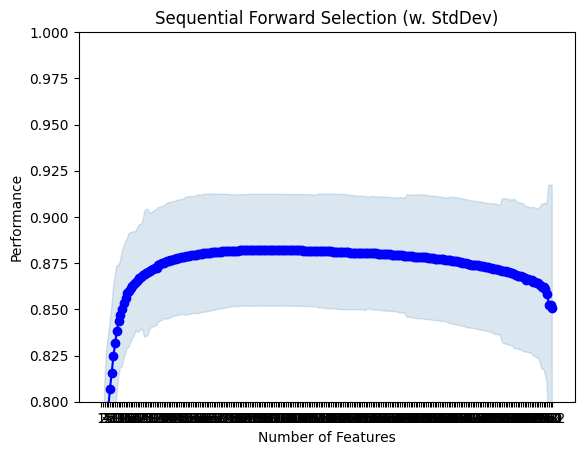

In [77]:
plot_sfs(sfs_forward.get_metric_dict(), kind='std_dev')
plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.show()

In [ ]:
# We see that we can maybe take less values, to make it simpler, say around 40
sfs_forward.subsets_[35]['feature_names']

In [ ]:
# This takes a lot of time
# See https://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
X_train = df_encoded_train.fillna(0)
y_train = df_train['SalePrice']

sfs_backward = SFS(LinearRegression(),
          k_features=(3, 40), # Based on the SFS results, we expect something similar.
          forward=False,
          scoring='r2',
          cv=5)
sfs_backward = sfs_backward.fit(X_train, y_train)

In [ ]:
plot_sfs(sfs_backward.get_metric_dict(), kind='std_dev')
plt.ylim([0.8, 1])
plt.title('Sequential Backward Selection (w. StdDev)')
plt.show()

In [ ]:
# We see that we can maybe take less values, to make it simpler, say around 40
sfs_backward.subsets_[35]['feature_names']

In [83]:
X_train = df_encoded_train.fillna(0)
y_train = df_train['SalePrice']

random_forest_selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold="median")
X_rf_selected = random_forest_selector.fit(X_train, y_train)

In [84]:
print(f"Selected features ({random_forest_selector.get_support().sum()}):", X_train.columns[random_forest_selector.get_support()] )

Selected features (131): Index(['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
       '2nd Flr SF', 'Gr Liv Area',
       ...
       'Yr Sold_2009.0', 'Yr Sold_2008.0', 'Yr Sold_2007.0', 'Yr Sold_2006.0',
       'Sale Type_WD ', 'Sale Type_New', 'Sale Condition_Normal',
       'Sale Condition_Partial', 'Sale Condition_Family',
       'Sale Condition_Abnorml'],
      dtype='object', length=131)


In [73]:
X_train = df_encoded_train.fillna(0)
y_train = df_train['SalePrice']

lasso_selector = SelectFromModel(LassoCV(cv=5, random_state=42), threshold="median")
lasso_selector.fit(X_train, y_train)

,estimator,"LassoCV(cv=5, random_state=42)"
,threshold,'median'
,prefit,False
,norm_order,1
,max_features,None
,importance_getter,'auto'
,eps,0.001
,n_alphas,'deprecated'
,alphas,'warn'
,fit_intercept,True
,precompute,'auto'


In [81]:
print(f"Selected features ({lasso_selector.get_support().sum()}):", X_train.columns[lasso_selector.get_support()] )

Selected features (262): Index(['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF',
       ...
       'Sale Type_Oth', 'Sale Type_ConLw', 'Sale Type_CWD', 'Sale Type_VWD',
       'Sale Condition_Normal', 'Sale Condition_Partial',
       'Sale Condition_Family', 'Sale Condition_Abnorml',
       'Sale Condition_Alloca', 'Sale Condition_AdjLand'],
      dtype='object', length=262)


### Feature Extraction

We will consider:

- Principal Component Analysis (PCA)
- Singular Vector Decomposition (SVD)

#### PCA

PCA projects your features into new axes that maximize variance

- PCA tries to identify a set of new directions (new features) called principal components that account for the most variance (information)
- Principal components (new directions/features) are the linear combinations of the old directions (old features)
- PCA works well when relationships between features are linear
  + Inappropriate for non-normal data (i.e. skewed or discrete data) -> use unskewing techniques on skewed features prior PCA
- PCA is sensitive to the scale of the features
  + variance of features with larger scales will dominate the principal components
unless the data is standardized → use standard scaler prior PCA (Lab 4)
- PCA requires that features are mean-centered (mean=0)
  + for each feature, this is done by subtracting the mean of that feature from each data point - done by PCA in advance for all features
- PCA helps when the features in your dataset are correlated and you want to remove the redundancy in the data by transforming it into uncorrelated principal components
- PCA is unsupervised method - it ignores the target variable

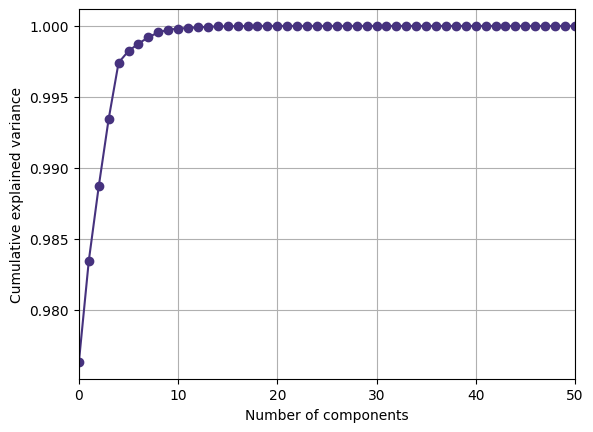

In [107]:
# PCA needs to use the standarized dataset
X_train = df_encoded_train.fillna(0)
y_train = df_train['SalePrice']

pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.xlim(0, 50)
plt.show()

Best n_components: 94
Best CV R²: 0.8366956639565778


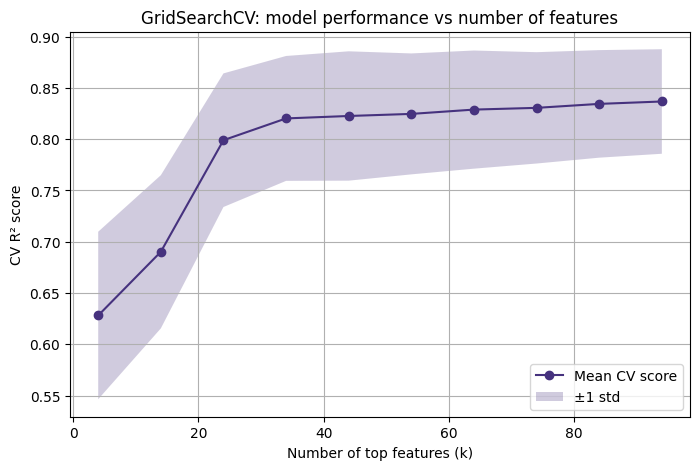

In [98]:
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('pca', PCA()),
    ('model', LinearRegression())
])

param_grid = {'pca__n_components': range(4, 100, 10)}
cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='r2')
grid.fit(X_train, y_train)

print("Best n_components:", grid.best_params_['pca__n_components'])
print("Best CV R2:", grid.best_score_)

results = pd.DataFrame(grid.cv_results_)
plt.figure(figsize=(8,5))
plt.plot(results['param_pca__n_components'], results['mean_test_score'], marker='o', label='Mean CV score')
plt.fill_between(
    results['param_pca__n_components'],
    results['mean_test_score'] - results['std_test_score'],
    results['mean_test_score'] + results['std_test_score'],
    alpha=0.25, label='±1 std'
)
plt.xlabel('Number of top features (k)')
plt.ylabel('CV R2 score')
plt.title('Model performance vs number of features')
plt.grid(True)
plt.legend()
plt.show()

From the elbow rule the best value is 34

Explained variance ratio: [9.76345727e-01 7.13690316e-03 5.21829030e-03 4.74706071e-03
 3.96505881e-03 8.22868054e-04 5.07096083e-04 4.63444043e-04
 3.31801217e-04 1.99816081e-04 6.58803668e-05 5.55417698e-05
 4.38662938e-05 4.10351732e-05 1.86864336e-05 1.47159933e-05
 9.65790348e-06 9.24252381e-06 2.99897478e-06 3.21331727e-08
 2.77414832e-08 1.93586454e-08 1.71179997e-08 1.48682260e-08
 1.31754141e-08 1.10201655e-08 9.10121320e-09 6.60748979e-09
 6.06194631e-09 5.42229996e-09 4.98360247e-09 4.71980712e-09
 4.65593746e-09 4.45187742e-09]


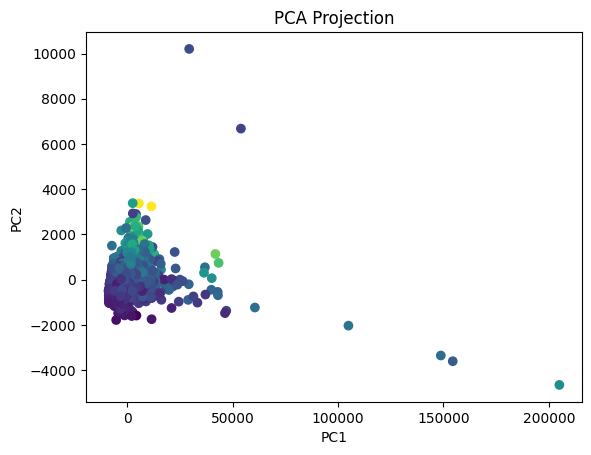

In [102]:
pca = PCA(n_components=34).fit(X_train)
print("Explained variance ratio:", pca.explained_variance_ratio_)

X_pca = pca.transform(X_train)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection of the top 2 principal components')
plt.show()

#### SVD

SVD is a generic way of breaking down a big matrix (dataset with features) into 3 smaller, more useful pieces

- SVD breaks a matrix (A) into three matrices: $A = U\Sigma V^T$
- Matrices U and V contain information about the "directions" or "features" of the original dataset - U contains info about rows, V info about columns
- $\Sigma$ is diagonal matrix with singular values. These are like "weights" that tell us how important certain directions (in U and V) are.
- So if your original matrix (dataset) is too big and complicated, you can use just the most important singular values (the biggest ones in $\Sigma$) and their corresponding vectors from U and V
- This helps you simplify the data while keeping most of its essential information
- SVD is a generic way of decomposing a matrix for purposes like dimensionality reduction, latent semantic analysis (LSA*) in text processing without necessarily focusing on variance
- It works well with sparse matrices, where many of the entries are zero (e.g., document-term frequency matrices in text processing)
- SVD does not require data to be mean-centered
- SVD is unsupervised method - it ignores the target variable

Best n_components: 95
Best CV R²: 0.8428855722442525


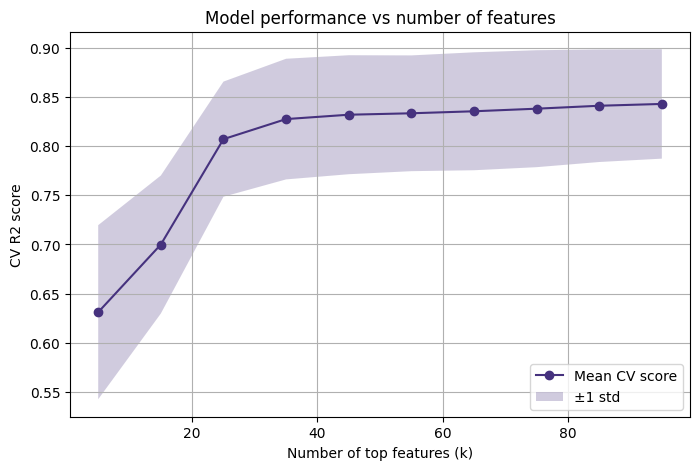

In [112]:
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('svd', TruncatedSVD()),
    ('model', LinearRegression())
])

param_grid = {'svd__n_components': range(5, 100, 10)}
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)

print("Best n_components:", grid.best_params_['svd__n_components'])
print("Best CV R²:", grid.best_score_)

results = pd.DataFrame(grid.cv_results_)
plt.figure(figsize=(8,5))
plt.plot(results['param_svd__n_components'], results['mean_test_score'], marker='o', label='Mean CV score')
plt.fill_between(
    results['param_svd__n_components'],
    results['mean_test_score'] - results['std_test_score'],
    results['mean_test_score'] + results['std_test_score'],
    alpha=0.25, label='±1 std'
)
plt.xlabel('Number of top features (k)')
plt.ylabel('CV R2 score')
plt.title('Model performance vs number of features')
plt.grid(True)
plt.legend()
plt.show()

In [113]:
# We select n_components based on the elbow rule

svd = TruncatedSVD(n_components=35, random_state=42)
X_svd = svd.fit_transform(X_train)

## Selected machine learning techniques

Our dataset contains sale prices and a faily detailed description of properties sold in the early 2000's, which contain the USA housing crash of 2008. Our dataset is fairly large with many predictors. Our objective is not to just predict housing prices, but also equaly important to understand which features are important for the price of a house. With this in mind we will outline some regression machine learning techniques that we consider that will perform well with our datset.

### Linear Regression

- Fits a straight-line relationship between predictors and SalePrice.
- Assumes linearity, no multicollinearity, and normally distributed residuals.
- Works best after feature scaling and log-transforming SalePrice.
- Gives interpretable model and understanding of feature importance.

#### Ridge Regression (L2 Regularization)

- Adds a penalty on large coefficients to reduce overfitting.
- Helps when you have many correlated predictors.
- Helps with multicollinearity.

#### Lasso Regression (L1 Regularization)

- Performs feature selection by shrinking some coefficients to zero.
- Excellent for high-dimensional data after one-hot encoding.
- Gives automatic feature selection.

### Tree-Based Models

- Can capture nonlinear interactions automatically

#### Decision Tree Regressor

- Splits data into regions and fits piecewise constant predictions.
- Highly interpretable but prone to overfitting unless depth-limited.
- Gives interpretable model of decision rules.

#### Random Forest Regressor

- Ensemble of many trees using bagging (random sampling).
- Reduces variance and overfitting.
- Handles missing values, nonlinearities, and interactions automatically.

#### Gradient Boosted Trees (e.g., XGBoost, LightGBM, CatBoost)

- Sequentially builds trees that correct the errors of previous ones.
- Extremely powerful and usually achieves state-of-the-art results on tabular data.
- Handles mixed feature types well (especially CatBoost).

### Support Vector Regression (SVR)

- Extends SVMs to regression.
- Uses kernel functions to model nonlinear relationships.
- Sensitive to feature scaling — must standardize inputs.

### Neural Network Regressors (MLP)

- Fully connected feed-forward networks can learn nonlinear relationships.
- Requires normalization, more data, and tuning.
- Can be outperformed by gradient boosting on smaller tabular datasets.

## Model Comparison and Evaluation

We will regress on the `SalePrice`, so the metrics we will be using are:

- Mean Absolute Error (MAE) - interpretable in currency units.
- Root Mean Squared Error (RMSE) - penalizes larger errors.
- $R^2$ score - proportion of variance explained.
